# Purpose of this notebook = leverage knowledge about neighbors' formation thicknesses

## What a geologist would do: 
#### Look at neighboring wells to find thickness of unit from a top and base pick, in prediction well flatten on base pick, and see where neighboring top pick lands on well in question. Further evaluation starts there. 
## Feature creation summary:
#### Find thickness of unit in neighboring wells in training dataset. Subtract that thickness from the base pick depth in the well we're going to predict for to find where that top pick would be in the prediction well if the thickness is the same.


## Feature Creation Additional Details:
- We could get quite elaborate with this in terms of whether neighbors are on all sides of prediction well or just one side or which neighbors are most similar in terms of total depth drilled, variances in gamma-ray, etc. 
- For now, we're going going to create two features (1) a prediction feature based on nearest neighbor thickness (2) a prediction feature based on average of nearest 5 neighbors. 
- Neighbor thickness helper features columns will be floats representing the distance from the depth predicted from neighbor thickness and prediction well base pick.
- We will also have column to keep track of the range between the smallest and largest neighbor thickness of that well. 
- This feature creation requires the things below, if they aren't present this shouldn't be used:
    - We have lat/long to determine neighbors.
    - We have a base pick and a top pick for each well.
    - We have reason to believe the thickness of neighbors is a good indicator or where the top will be in this well. Reasons that wouldn't be the case include: presence of faults, known local outliers, and possibly other things I haven't thought of yet. 

In [2]:
# Notebook to find: 
## 1. Check that we have created a subset of wells to use that have both tops and bases for a given unit.
## 2. A number of nearest neighbors of each well
## 3. Thickness of one or more zones for each nearest neighbor in set of n nearest neighbors
## 4. Where in the well a top would be predicted just based on base of unit and thickness of neighbors
### 4. b. Thickness of closest neighbor with both a top and a base
### 4.c Average thickness of nearest N neighbors
### 5. NOTE: We'll want to only use neighbors from the train data samples for the train rows and use both train and test neighbors for test rows. For this, we'll want to already have test and train classes assigned!

### Earlier notebooks were to explore lat/long position of wells & find nearest neighbors and functions to make a dataset of nearest neighbors within certain limits for each well and potentially functions to make a dataset of tops and other characteristics for neighboring wells.
### 

## Import modules and set display options

In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)
import re

folium 0.5.0
welly 0.3.5


In [4]:
%%timeit
import os
env = %env

81.2 µs ± 4.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
pd.set_option('display.max_rows', 2000)

## Load pick, pick dictionary, well information, and well location via csv and text file


In [6]:
picks_dic = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../../well_lat_lng.csv')

## Dataframe of well curves data created in load notebook

In [7]:
loaded_wells_dir = '../loadLAS/'
loaded_wells_splitTrainTest_dir = '../splitTrainTest/'
# loaded_wells_df = 'df_all_wells_noKNNorFeatures_20180920_a.h5'
# h5_filename_df_wells_wTrainTestSplitCol = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

loaded_wells_splitTrainTest_df = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

## Give top pick code that we want to predict
## and give base pick code that we want to assume we have 

In [8]:
####old verbage
# picks_new=picks[picks['HorID']==13000]
# picks_paleoz=picks[picks['HorID']==14000]

#### top pick code we are going to predict
picks_targetTop=picks[picks['HorID']==13000]
#### base pick code we are going to assume we have
picks_targetBase=picks[picks['HorID']==14000]

#### Note: these need to be in this order as we'll assume the second one will be written as 'HorID_x' by pandas as two columns can't have the same name

## Merge information from the various files into a pandas dataframe

In [9]:


df_new = pd.merge(wells, picks_targetTop, on='SitID')
df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [10]:
df_new.tail()

SitID    UWI (AGS)_x                UWI_x  HorID_x  Pick_x  Quality_x  \
2188  126239  1014133011AA0  AA/11-30-101-13W4/0    14000     497          1   
2189  126240  1014140811AA0  AA/11-08-101-14W4/0    14000     505          2   
2190  126241  1014141414AA0  AA/14-14-101-14W4/0    14000  502.31          1   
2191  126243  1014142906AA0  AA/06-29-101-14W4/0    14000     538          1   
2192  126244  1014143506AA0  AA/06-35-101-14W4/0    14000     584          1   

        UWI (AGS)_y                UWI_y  HorID_y  Pick_y  Quality_y  \
2188  1014133011AA0  AA/11-30-101-13W4/0    13000     457          3   
2189  1014140811AA0  AA/11-08-101-14W4/0    13000     481          2   
2190  1014141414AA0  AA/14-14-101-14W4/0    13000  471.22          3   
2191  1014142906AA0  AA/06-29-101-14W4/0    13000     517          2   
2192  1014143506AA0  AA/06-35-101-14W4/0    13000   539.7          1   

            lat         lng      UWI (AGS)                  UWI  HorID  \
2188  57.796978 -112.129423  1014133011AA0  AA/11-30-101-13W4/0  13000   
2189  57.753273 -112.266195  1014140811AA0  AA/11-08-101-14W4/0  13000   
2190  57.771518 -112.184135  1014141414AA0  AA/14-14-101-14W4/0  13000   
2191  57.793366 -112.266201  1014142906AA0  AA/06-29-101-14W4/0  13000   
2192  57.807817 -112.184139  1014143506AA0  AA/06-35-101-14W4/0  13000   

        Pick  Quality  
2188     457        3  
2189     481        2  
2190  471.22        3  
2191     517        2  
2192   539.7        1

In [11]:
# ## Possible Steps to Chain for some of the possible features
# 0. Save and access pickle of all the CSVs chained into single data frame
# 1. Return array of UWIs of K neighbor wells, place as list in data frame
# 2. Place nearest well UWI of each well into new column 
# 3. Place nearest well pick depths into new column
# 4. place average pick depths of the array of wells into new column
# 5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
# 6. Calculate nearest and average value for distance between pick in question and known pick.

## Now let's import the dataframe of wells that have the tops and curves we want and limit the GIS dataframe to only those wells!

In [12]:
wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')

In [13]:
wellsLoaded_df_fromh5.tail()

CALI  COND  DELT     DEPT   DPHI  DT      GR    ILD  ILM   NPHI  PHID  \
959  243.882   NaN   NaN  764.006  0.136 NaN  26.517  4.595  NaN  0.468   NaN   
960  243.751   NaN   NaN  764.256  0.124 NaN  33.226  4.490  NaN  0.460   NaN   
961  244.046   NaN   NaN  764.506  0.104 NaN   2.654  4.395  NaN  0.449   NaN   
962  244.763   NaN   NaN  764.756  0.072 NaN   7.806  4.327  NaN  0.453   NaN   
963  245.368   NaN   NaN  765.006  0.056 NaN  11.962  4.284  NaN  0.462   NaN   

     RHOB  SFL  SFLU  SN  SP                      UWI trainOrTest  
959   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
960   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
961   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
962   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
963   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train

## Let's limit the GIS and pick information dataframe to only the wells we're going to use and exclude any we're not going to use for not having the needed tops and curves.

We'll have to change the format of the UWU col slightly to do this

In [14]:
wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()

In [15]:
len(wellsLoaded_list)

1601

In [16]:
wellsLoaded_list[9:14]

array(['00-11-09-079-15W4-0.LAS', '00-08-29-077-10W4-0.LAS',
       'AA-15-14-101-13W4-0.LAS', '00-10-20-075-18W4-0.LAS',
       '00-10-27-078-07W4-0.LAS'], dtype=object)

In [17]:
def replacenthSubStr(string, sub, wanted, n):
    where = [m.start() for m in re.finditer(sub, string)][n-1]
    before = string[:where]
    after = string[where:]
    after = after.replace(sub, wanted, 1)
    newString = before + after
    return newString

In [18]:
def changeLASfileToBeUWIstr(lasStr):
    string1 = replacenthSubStr(lasStr,'-', '/', 5)
    string2 = replacenthSubStr(string1,'-', '/', 1).replace(".LAS","")
    return string2

In [19]:
def findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5):
    wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
    new_wells_loaded_list_inUWIstyle = []
    for lasStr in wellsLoaded_list:
        new_wells_loaded_list_inUWIstyle.append(changeLASfileToBeUWIstr(lasStr))
    return new_wells_loaded_list_inUWIstyle

In [20]:
new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)

In [21]:
new_wells_loaded_list_inUWIstyle[5:8]

['00/15-20-072-21W4/0', '00/11-04-092-18W4/0', '00/07-36-075-23W4/0']

In [195]:
print(type(new_wells_loaded_list_inUWIstyle))

<class 'list'>


In [197]:
print(type(df_new))

<class 'pandas.core.frame.DataFrame'>


In [198]:
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [196]:
df_new_allWells = df_new.copy()
len(df_new_allWells)

1601

### This next step will reduce the total number of wells to just the ones that have at least the tops and curves we need

In [23]:
df_new = df_new[df_new['UWI'].isin(new_wells_loaded_list_inUWIstyle)]

Now that we've reduced the wells, we'll reset the index. We'll do this because another step below will use a loop that gets confused if there are index values missing. 

In [24]:
df_new = df_new.reset_index(drop=True)

In [25]:
df_new

SitID    UWI (AGS)_x                UWI_x  HorID_x  Pick_x  Quality_x  \
0     102496  0674010812000  00/12-08-067-01W4/0    14000     561          1   
1     102497  0674020807000  00/07-08-067-02W4/0    14000   604.5          1   
2     102498  0674021109000  00/09-11-067-02W4/0    14000     564          1   
3     102500  0674022910000  00/10-29-067-02W4/0    14000   636.5          1   
4     102501  0674023406000  00/06-34-067-02W4/0    14000     613          1   
5     102503  0674030411000  00/11-04-067-03W4/0    14000   553.5          1   
6     102505  0674030810000  00/10-08-067-03W4/0    14000   572.5          1   
7     102507  0674031410000  00/10-14-067-03W4/0    14000   606.5          1   
8     102514  0674032810000  00/10-28-067-03W4/0    14000     558          1   
9     102517  0674033607000  00/07-36-067-03W4/0    14000     615          1   
10    102518  0674040210000  00/10-02-067-04W4/0    14000   588.5          1   
11    102565  0674040710000  00/10-07-067-04W4/0    14000   568.5          1   
12    102577  0674042411000  00/11-24-067-04W4/0    14000     552          1   
13    102581  0674043307000  00/07-33-067-04W4/0    14000     570          1   
14    102583  0674050313000  00/13-03-067-05W4/0    14000   543.5          1   
15    102589  0674051606000  00/06-16-067-05W4/0    14000     540          1   
16    102592  0674052507000  00/07-25-067-05W4/0    14000   557.5          1   
17    102596  0674053310000  00/10-33-067-05W4/0    14000   533.5          1   
18    102597  0674060115000  00/15-01-067-06W4/0    14000   531.5          1   
19    102606  0674061706000  00/06-17-067-06W4/0    14000     533          1   
20    141727  0674062307000  00/07-23-067-06W4/0    14000   534.5          1   
21    102609  0674062902000  00/02-29-067-06W4/0    14000     543          1   
22    102610  0674070511000  00/11-05-067-07W4/0    14000     537          1   
23    102611  0674071306000  00/06-13-067-07W4/0    14000     544          1   
24    102614  0674072503000  00/03-25-067-07W4/0    14000     535          2   
25    102615  0674072908000  00/08-29-067-07W4/0    14000     592          1   
26    102619  0674080310000  00/10-03-067-08W4/0    14000     534          2   
27    102620  0674081306000  00/06-13-067-08W4/0    14000     555          2   
28    141732  0674082910000  00/10-29-067-08W4/0    14000     550          1   
29    102626  0674083407000  00/07-34-067-08W4/0    14000   560.5          1   
30    163611  0674102706000  00/06-27-067-10W4/0    14000   567.5          1   
31    163612  0674103109000  00/09-31-067-10W4/0    14000   571.5          1   
32    102630  0674110603000  00/03-06-067-11W4/0    14000     562          4   
33    163614  0674113310000  00/10-33-067-11W4/0    14000     545          1   
34    141733  0674120207000  00/07-02-067-12W4/0    14000     525          1   
35    102633  0674120508000  00/08-05-067-12W4/0    14000     473          1   
36    102640  0674121306000  00/06-13-067-12W4/0    14000   521.5          1   
37    141734  0674122208002  00/08-22-067-12W4/2    14000     461          3   
38    102656  0674130311000  00/11-03-067-13W4/0    14000     498          4   
39    102666  0674133410000  00/10-34-067-13W4/0    14000  458.42          3   
40    102671  0674133611000  00/11-36-067-13W4/0    14000  480.06          1   
41    102672  0674140306000  00/06-03-067-14W4/0    14000     517          2   
42    102679  0674140812000  00/12-08-067-14W4/0    14000     498          1   
43    102681  0674141011000  00/11-10-067-14W4/0    14000   497.5          3   
44    102684  0674141813000  00/13-18-067-14W4/0    14000   489.5          2   
45    102686  0674150208000  00/08-02-067-15W4/0    14000     508          1   
46    141736  0674150610000  00/10-06-067-15W4/0    14000   533.5          1   
47    102698  0674152211000  00/11-22-067-15W4/0    14000     538          1   
48    102702  0674153106000  00/06-31-067-15W4/0    14000  536.45          1   
49    1

## We'll now find nearest N neighbors using a kdtree approach

In [26]:
position = df_new[['lat','lng']]

In [27]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [28]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf3.p", "wb" ) )
!ls

MM_Top_Depth_Real_v_predBy_NN1thick_v2.html
latlng_kd_tree_leaf2b.p
latlng_kd_tree_leaf3.p
wellKNN_wKDtree-Post062018_vB.ipynb
wellKNN_wKDtree-Post092018_vC.ipynb
wellKNN_wKDtree-Post092018_vD.ipynb
wellKNN_wKDtree-Post092018_vE_testSplittrain.ipynb
wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p
wells_df__NB_KDtreePost062018_vA__v1.p
wells_df__NB_KDtreePost092018_vB__v1.p
wells_df__NB_KDtreePost20180927_test_v3.p
wells_df__NB_KDtreePost20180927_vA__NoMcTopLeak_v3.p


### Let's make sure the kd_tree worked as indended by checking to see if two wells identified as being located near each other in fact have latitude and longitude that is close to each other.

In [29]:
dist, ind = tree.query([position][0], k=8)  

In [30]:
len(dist)

1601

In [31]:
len(ind)

1601

In [32]:
ind[4:5]

array([[ 4,  3, 56, 55,  2,  1, 57, 58]])

In [33]:
df_new[63:64]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
63  103715  0684040211000  00/11-02-068-04W4/0    14000    577          1   

      UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y       lat  \
63  0684040211000  00/11-02-068-04W4/0    13000    511          1  54.85873   

           lng      UWI (AGS)                  UWI  HorID Pick  Quality  
63 -110.504559  0684040211000  00/11-02-068-04W4/0  13000  511        1

In [34]:
df_new[4:5]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file that was created above:

In [35]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf3.p")
# latlng_kd_tree_leaf2b.p

In [36]:
#### Finding 8 nearest neighbors based on lat/long
#### K is number of neighbors
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [37]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   54 ...    1   57    3]
 [   1    3    4 ...    2   55   60]
 [   2    0    4 ...    3   54   55]
 ...
 [1598 1599 1591 ... 1597 1587 1582]
 [1599 1598 1600 ... 1584 1594 1587]
 [1600 1597 1599 ... 1591 1596 1589]] [[0.         0.057531   0.0874943  ... 0.14017283 0.14539497 0.14676425]
 [0.         0.04734001 0.07332214 ... 0.08267377 0.09089701 0.11681159]
 [0.         0.057531   0.06649379 ... 0.09343692 0.10808167 0.12013968]
 ...
 [0.         0.040093   0.04404393 ... 0.14358519 0.15437856 0.15533278]
 [0.         0.040093   0.08332469 ... 0.17815722 0.18808135 0.18953798]
 [0.         0.05577925 0.08332469 ... 0.12364274 0.13721611 0.17046897]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

###### F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [38]:
ind[0]

array([ 0,  2, 54, 56,  4,  1, 57,  3])

## This will add a new column to the dataframe that has an object that contains
### 1. {'neighbor': integer, 'UWI': 'string', 'distance': float}
### for N number of neighbors

In [39]:
def makeKNearNeighObj(df_new,pickleFileOfKDtree,numberNeighbors):
    #### Takes in 
    #### Returns 
    
    ##### first part......
    #### make a data frame of UWI & index from main dataframe
    UWIs = df_new[['UWI']]
    position = df_new[['lat','lng']]
    #UWIs.join(position, how='outer') 
    UWIs_Geog = pd.concat([UWIs, position], axis=1)
    #print(UWIs_Geog.head())
    #### Add object of tree for 8 neighbors to a dataframe
    latlng_kd_tree_leaf2 = pd.read_pickle(pickleFileOfKDtree)
    #### Finding 8 nearest neighbors based on lat/long
    #### K is number of neighbors
    dist, ind = latlng_kd_tree_leaf2.query([position][0], k=numberNeighbors) 
    neighbor_array_per_well_row = []
    #### for i in ind.length
    for i in range(len(ind)):
        #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
        neighbors_ind = ind[i][1:]
        # for each index in that array, 
        counter = 1
        array_of_holder_obj = []
        for n in neighbors_ind:
            #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
            holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
            #### get the distance into the temp object using index of i and each,
            holder_obj['distance'] = dist[i][counter]
            #### get the UWI using i and the dataframe
            holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
            #### and position via "counter"
            holder_obj['neighbor'] = counter
            #### add the temp object populated as a column entry into an array
            counter = counter + 1
            array_of_holder_obj.append(holder_obj)
        #### turn array of objects into series and add as new column to dataframe
        neighbor_array_per_well_row.append(array_of_holder_obj)
    UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)
    return UWIs_Geog

In [40]:
UWIs_Geog = makeKNearNeighObj(df_new,"latlng_kd_tree_leaf3.p",8)
UWIs_Geog.head()

UWI        lat         lng  \
0  00/12-08-067-01W4/0  54.785907 -110.129320   
1  00/07-08-067-02W4/0  54.782284 -110.269446   
2  00/09-11-067-02W4/0  54.785892 -110.186851   
3  00/10-29-067-02W4/0  54.829624 -110.269422   
4  00/06-34-067-02W4/0  54.840471 -110.224832   

                                       Neighbors_Obj  
0  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

In [41]:
#### Test results Part 1

#### Had to change display options to get this to print in full!
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     pd.set_option('display.max_rows', 500)
#     pd.set_option('display.max_columns', 500)
#     pd.set_option('display.width', 1000)
#     pd.options.display.max_colwidth = 100000
#     print(UWIs_Geog[0:1]['Neighbors_Obj'])

## Now to clean the df_new dataframe, rename columns, and merge with the new dataframe that has the neighbors!

In [42]:
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [241]:
def cleanRenameDF(df,topTarget,thicknessHelperTop):
    #### Takes in 
    #### Returns
    #### HorID and Pick should be for the topTarget & HorID_x and Pick_x should be for helper top which is a base of the unit
    #### First step is to check the assumption above:
    if df['HorID'][0:1][0] != topTarget or df['HorID_x'][0:1][0] != thicknessHelperTop:
        return "THERE WAS A PROBLEM AND THE COLUMNS AND TOPS VALUES DONT MATCH IN cleanRenameDF"
    else:
        df_new_cleaned = df[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()
        df_new_cleaned['TopHelper_HorID'] = df_new_cleaned['HorID_x']
        df_new_cleaned['TopTarget_HorID'] = df_new_cleaned['HorID']
        df_new_cleaned['TopHelper_DEPTH'] = df_new_cleaned['Pick_x']
        df_new_cleaned['TopTarget_DEPTH'] = df_new_cleaned['Pick']
        df_new_cleaned['TopHelper_HorID_Qual'] = df_new_cleaned['Quality_x']
        df_new_cleaned['TopTarget_Qual'] = df_new_cleaned['Quality']
        df_new_cleaned = df_new_cleaned[['SitID','lat','lng','UWI','TopHelper_HorID','TopTarget_HorID','TopHelper_DEPTH','TopTarget_DEPTH','TopHelper_HorID_Qual','TopTarget_Qual']]
    return df_new_cleaned

In [44]:
df_new_cleaned = cleanRenameDF(df_new,13000,14000)

In [45]:
type(df_new_cleaned)

pandas.core.frame.DataFrame

In [46]:
df_new_cleaned.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual  
0               3  
1               3  
2               3  
3               3  
4               2

#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [47]:
def mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog):
    df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
    return df_new_cleaned_plus_nn
    

In [48]:
df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)

In [49]:
df_new_cleaned_plus_nn.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [50]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}

In [51]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['distance']

0.07846755926496476

In [52]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [53]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,6]

'561'

In [54]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,7]

'475'

In [55]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [56]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.05753100195547899},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.08728400165551212},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.09343691917544036},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [57]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [58]:
df_new_cleaned_plus_nn.iloc[0,10][2]['UWI']

'00/09-11-068-02W4/0'

In [59]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [220]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        print("len(df)",len(df))
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [61]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH')

0   NaN
Name: NN1_topTarget_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  54
pick_depth  544
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
4
<class 'str'> type to right of  00/09-11-068-02W4/0


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index_of_neigh_UWI=  56
pick_depth  514
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  63
pick_depth  511
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  63
pick_depth  511
14
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  481
15
<class

93
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  94
pick_depth  470
94
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  141
pick_depth  460
95
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  141
pick_depth  460
96
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  97
pick_depth  457.2
97
<class 'str'> type to right of  00/11-36-067-13W4/0
index_of_neigh_UWI=  40
pick_depth  466.34
98
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  96
pick_depth  457.2
99
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  96
pick_depth  457.2
100
<class 'str'> type to right of  00/07-07-069-13W4/0
index_of_neigh_UWI=  145
pick_depth  420.93
101
<class 'str'> type to right of  00/07-21-069-14W4/0
index_of_neigh_UWI=  149
pick_depth  457.2
102
<class 'str'> type to right of  00/06-08-069-15W4/0
index_of_neigh_UWI=  151
pick_depth  434.64
103
<class 'str'> type to

index_of_neigh_UWI=  176
pick_depth  428
178
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  177
pick_depth  424
179
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  181
pick_depth  456.55
180
<class 'str'> type to right of  00/07-35-070-11W4/0
index_of_neigh_UWI=  186
pick_depth  453
181
<class 'str'> type to right of  00/11-05-071-10W4/0
index_of_neigh_UWI=  261
pick_depth  475
182
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  181
pick_depth  456.55
183
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  180
pick_depth  464
184
<class 'str'> type to right of  00/06-31-070-11W4/0
index_of_neigh_UWI=  185
pick_depth  435.5
185
<class 'str'> type to right of  00/06-07-070-11W4/0
index_of_neigh_UWI=  184
pick_depth  436.78
186
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  180
pick_depth  464
187
<class 'str'> type to right of  00/11-21-070-12W4/0
index_of_neigh_UWI=

index_of_neigh_UWI=  265
pick_depth  470
262
<class 'str'> type to right of  00/16-34-071-10W4/0
index_of_neigh_UWI=  264
pick_depth  475
263
<class 'str'> type to right of  00/11-05-071-10W4/0
index_of_neigh_UWI=  261
pick_depth  475
264
<class 'str'> type to right of  00/05-13-071-10W4/0
index_of_neigh_UWI=  262
pick_depth  496
265
<class 'str'> type to right of  00/06-19-071-10W4/0
index_of_neigh_UWI=  263
pick_depth  475.5
266
<class 'str'> type to right of  00/11-29-071-11W4/0
index_of_neigh_UWI=  267
pick_depth  423
267
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  353
pick_depth  476
268
<class 'str'> type to right of  00/11-29-071-11W4/0
index_of_neigh_UWI=  267
pick_depth  423
269
<class 'str'> type to right of  00/11-25-071-12W4/0
index_of_neigh_UWI=  271
pick_depth  435
270
<class 'str'> type to right of  00/13-15-071-12W4/0
index_of_neigh_UWI=  269
pick_depth  438
271
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  353
pic

index_of_neigh_UWI=  264
pick_depth  475
349
<class 'str'> type to right of  00/06-01-072-11W4/0
index_of_neigh_UWI=  352
pick_depth  473.5
350
<class 'str'> type to right of  00/11-32-072-09W4/0
index_of_neigh_UWI=  347
pick_depth  459
351
<class 'str'> type to right of  00/10-06-073-10W4/0
index_of_neigh_UWI=  429
pick_depth  474.27
352
<class 'str'> type to right of  00/11-34-071-11W4/0
index_of_neigh_UWI=  268
pick_depth  459.5
353
<class 'str'> type to right of  00/09-13-072-12W4/0
index_of_neigh_UWI=  358
pick_depth  474
354
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  353
pick_depth  476
355
<class 'str'> type to right of  00/11-34-071-11W4/0
index_of_neigh_UWI=  268
pick_depth  459.5
356
<class 'str'> type to right of  00/11-25-071-12W4/0
index_of_neigh_UWI=  271
pick_depth  435
357
<class 'str'> type to right of  00/10-20-071-12W4/0
index_of_neigh_UWI=  270
pick_depth  436.47
358
<class 'str'> type to right of  00/08-01-072-12W4/0
index_of_neigh_UWI

index_of_neigh_UWI=  435
pick_depth  468.78
434
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  519
pick_depth  460
435
<class 'str'> type to right of  00/12-10-074-11W4/0
index_of_neigh_UWI=  522
pick_depth  469
436
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  519
pick_depth  460
437
<class 'str'> type to right of  00/07-29-072-12W4/0
index_of_neigh_UWI=  359
pick_depth  449
438
<class 'str'> type to right of  00/06-07-073-11W4/0
index_of_neigh_UWI=  433
pick_depth  476.5
439
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  525
pick_depth  480
440
<class 'str'> type to right of  00/13-22-073-13W4/0
index_of_neigh_UWI=  441
pick_depth  497.5
441
<class 'str'> type to right of  00/07-36-073-13W4/0
index_of_neigh_UWI=  443
pick_depth  480.5
442
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  533
pick_depth  520
443
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  

527
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  525
pick_depth  480
528
<class 'str'> type to right of  00/06-13-075-12W4/0
index_of_neigh_UWI=  601
pick_depth  478
529
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  442
pick_depth  504
530
<class 'str'> type to right of  00/11-06-074-13W4/0
index_of_neigh_UWI=  529
pick_depth  521
531
<class 'str'> type to right of  00/06-33-074-13W4/0
index_of_neigh_UWI=  532
pick_depth  546.81
532
<class 'str'> type to right of  00/10-17-074-13W4/0
index_of_neigh_UWI=  530
pick_depth  546
533
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  442
pick_depth  504
534
<class 'str'> type to right of  00/11-36-074-15W4/0
index_of_neigh_UWI=  540
pick_depth  575.46
535
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  533
pick_depth  520
536
<class 'str'> type to right of  00/07-03-075-14W4/0
index_of_neigh_UWI=  609
pick_depth  595
537
<class 'str'> type t

617
<class 'str'> type to right of  00/06-34-074-16W4/0
index_of_neigh_UWI=  541
pick_depth  499.26
618
<class 'str'> type to right of  00/06-34-074-16W4/0
index_of_neigh_UWI=  541
pick_depth  499.26
619
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  615
pick_depth  552
620
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  615
pick_depth  552
621
<class 'str'> type to right of  00/11-35-075-18W4/0
index_of_neigh_UWI=  622
pick_depth  432.21
622
<class 'str'> type to right of  00/07-32-074-18W4/0
index_of_neigh_UWI=  545
pick_depth  449.28
623
<class 'str'> type to right of  00/06-31-074-19W4/0
index_of_neigh_UWI=  547
pick_depth  486.46
624
<class 'str'> type to right of  00/10-22-075-21W4/0
index_of_neigh_UWI=  626
pick_depth  551.69
625
<class 'str'> type to right of  00/06-26-075-21W4/0
index_of_neigh_UWI=  627
pick_depth  576.07
626
<class 'str'> type to right of  00/10-16-075-21W4/0
index_of_neigh_UWI=  625
pick_depth  546.2
627
<cl

703
<class 'str'> type to right of  00/11-03-077-21W4/0
index_of_neigh_UWI=  776
pick_depth  598.02
704
<class 'str'> type to right of  00/11-03-077-21W4/0
index_of_neigh_UWI=  776
pick_depth  598.02
705
<class 'str'> type to right of  00/11-20-075-22W4/0
index_of_neigh_UWI=  628
pick_depth  559.61
706
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  778
pick_depth  634.59
707
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  778
pick_depth  634.59
708
<class 'str'> type to right of  00/07-23-076-22W4/0
index_of_neigh_UWI=  706
pick_depth  630.33
709
<class 'str'> type to right of  00/01-24-075-24W4/0
index_of_neigh_UWI=  637
pick_depth  602
710
<class 'str'> type to right of  00/06-21-075-25W4/0
index_of_neigh_UWI=  640
pick_depth  642.52
711
<class 'str'> type to right of  00/05-23-076-01W5/0
index_of_neigh_UWI=  712
pick_depth  773
712
<class 'str'> type to right of  00/10-27-075-01W5/0
index_of_neigh_UWI=  642
pick_depth  740.66
713
<c

787
<class 'str'> type to right of  00/07-01-077-03W5/0
index_of_neigh_UWI=  788
pick_depth  690.68
788
<class 'str'> type to right of  00/06-29-077-02W5/0
index_of_neigh_UWI=  787
pick_depth  597
789
<class 'str'> type to right of  00/07-10-078-03W5/0
index_of_neigh_UWI=  870
pick_depth  589.79
790
<class 'str'> type to right of  00/07-09-077-04W5/0
index_of_neigh_UWI=  791
pick_depth  640.69
791
<class 'str'> type to right of  00/07-16-077-04W5/0
index_of_neigh_UWI=  793
pick_depth  621.18
792
<class 'str'> type to right of  00/10-18-076-03W5/0
index_of_neigh_UWI=  715
pick_depth  782
793
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  790
pick_depth  650.14
794
<class 'str'> type to right of  00/05-19-079-02W4/0
index_of_neigh_UWI=  873
pick_depth  264
795
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  797
pick_depth  298
796
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  797
pick_depth  298
797
<class 'str

index_of_neigh_UWI=  797
pick_depth  298
876
<class 'str'> type to right of  00/02-17-079-03W4/0
index_of_neigh_UWI=  877
pick_depth  309.5
877
<class 'str'> type to right of  00/07-06-079-03W4/0
index_of_neigh_UWI=  875
pick_depth  295.5
878
<class 'str'> type to right of  00/06-19-078-04W4/0
index_of_neigh_UWI=  800
pick_depth  314
879
<class 'str'> type to right of  00/10-33-079-04W4/0
index_of_neigh_UWI=  881
pick_depth  215.8
880
<class 'str'> type to right of  00/10-33-079-04W4/0
index_of_neigh_UWI=  881
pick_depth  215.8
881
<class 'str'> type to right of  00/10-10-080-04W4/0
index_of_neigh_UWI=  953
pick_depth  243.84
882
<class 'str'> type to right of  00/08-09-079-05W4/0
index_of_neigh_UWI=  883
pick_depth  252
883
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  882
pick_depth  274
884
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  882
pick_depth  274
885
<class 'str'> type to right of  00/12-20-079-05W4/0
index_of_neigh_UWI=

index_of_neigh_UWI=  969
pick_depth  393.5
969
<class 'str'> type to right of  00/03-11-080-08W4/0
index_of_neigh_UWI=  967
pick_depth  355.5
970
<class 'str'> type to right of  AA/07-26-080-08W4/0
index_of_neigh_UWI=  969
pick_depth  393.5
971
<class 'str'> type to right of  00/10-16-079-09W4/0
index_of_neigh_UWI=  900
pick_depth  414.53
972
<class 'str'> type to right of  AA/10-26-080-09W4/0
index_of_neigh_UWI=  973
pick_depth  444
973
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  1046
pick_depth  424.28
974
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  1046
pick_depth  424.28
975
<class 'str'> type to right of  00/03-03-081-10W4/0
index_of_neigh_UWI=  1048
pick_depth  422
976
<class 'str'> type to right of  00/05-15-080-11W4/0
index_of_neigh_UWI=  977
pick_depth  417.5
977
<class 'str'> type to right of  00/12-36-079-11W4/0
index_of_neigh_UWI=  906
pick_depth  430
978
<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_n

index_of_neigh_UWI=  1058
pick_depth  339
1062
<class 'str'> type to right of  00/06-25-082-15W4/0
index_of_neigh_UWI=  1140
pick_depth  300.5
1063
<class 'str'> type to right of  00/10-26-081-16W4/0
index_of_neigh_UWI=  1064
pick_depth  308
1064
<class 'str'> type to right of  00/11-26-080-16W4/0
index_of_neigh_UWI=  996
pick_depth  341
1065
<class 'str'> type to right of  00/06-06-082-17W4/0
index_of_neigh_UWI=  1145
pick_depth  314.55
1066
<class 'str'> type to right of  00/10-01-082-17W4/0
index_of_neigh_UWI=  1144
pick_depth  287.73
1067
<class 'str'> type to right of  00/10-14-081-17W4/0
index_of_neigh_UWI=  1066
pick_depth  306.02
1068
<class 'str'> type to right of  00/15-36-080-19W4/0
index_of_neigh_UWI=  1003
pick_depth  361.19
1069
<class 'str'> type to right of  00/11-09-082-19W4/0
index_of_neigh_UWI=  1149
pick_depth  362.1
1070
<class 'str'> type to right of  00/10-35-080-20W4/0
index_of_neigh_UWI=  1006
pick_depth  376.12
1071
<class 'str'> type to right of  00/10-32-080

index_of_neigh_UWI=  1166
pick_depth  227.5
1168
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1167
pick_depth  207.87
1169
<class 'str'> type to right of  00/07-24-082-05W4/0
index_of_neigh_UWI=  1108
pick_depth  200
1170
<class 'str'> type to right of  00/13-19-083-04W4/0
index_of_neigh_UWI=  1171
pick_depth  198
1171
<class 'str'> type to right of  00/14-20-083-04W4/0
index_of_neigh_UWI=  1172
pick_depth  184
1172
<class 'str'> type to right of  00/12-07-083-04W4/0
index_of_neigh_UWI=  1170
pick_depth  204.5
1173
<class 'str'> type to right of  00/06-21-082-05W4/0
index_of_neigh_UWI=  1107
pick_depth  209
1174
<class 'str'> type to right of  00/12-05-084-05W4/0
index_of_neigh_UWI=  1231
pick_depth  227
1175
<class 'str'> type to right of  00/10-33-082-06W4/0
index_of_neigh_UWI=  1110
pick_depth  232
1176
<class 'str'> type to right of  00/06-05-084-06W4/0
index_of_neigh_UWI=  1235
pick_depth  301
1177
<class 'str'> type to right of  00/10-23-083-07W4/0
ind

<class 'str'> type to right of  AA/13-14-084-12W4/0
index_of_neigh_UWI=  1251
pick_depth  274
1251
<class 'str'> type to right of  AA/08-11-084-12W4/0
index_of_neigh_UWI=  1250
pick_depth  277.37
1252
<class 'str'> type to right of  AA/13-14-084-12W4/0
index_of_neigh_UWI=  1251
pick_depth  274
1253
<class 'str'> type to right of  AA/13-14-084-12W4/0
index_of_neigh_UWI=  1251
pick_depth  274
1254
<class 'str'> type to right of  00/01-03-085-15W4/0
index_of_neigh_UWI=  1289
pick_depth  243
1255
<class 'str'> type to right of  00/01-03-085-15W4/0
index_of_neigh_UWI=  1289
pick_depth  243
1256
<class 'str'> type to right of  00/10-32-083-15W4/0
index_of_neigh_UWI=  1203
pick_depth  267.61
1257
<class 'str'> type to right of  00/01-05-085-15W4/0
index_of_neigh_UWI=  1290
pick_depth  253
1258
<class 'str'> type to right of  00/06-24-083-16W4/0
index_of_neigh_UWI=  1206
pick_depth  259.08
1259
<class 'str'> type to right of  00/07-34-083-16W4/0
index_of_neigh_UWI=  1207
pick_depth  261
1260
<

index_of_neigh_UWI=  1327
pick_depth  301.75
1357
<class 'str'> type to right of  AA/16-31-089-07W4/0
index_of_neigh_UWI=  1358
pick_depth  135
1358
<class 'str'> type to right of  AA/02-19-090-07W4/0
index_of_neigh_UWI=  1381
pick_depth  124
1359
<class 'str'> type to right of  AA/04-11-090-08W4/0
index_of_neigh_UWI=  1383
pick_depth  117
1360
<class 'str'> type to right of  AA/01-02-090-08W4/0
index_of_neigh_UWI=  1382
pick_depth  132
1361
<class 'str'> type to right of  AA/06-11-090-10W4/0
index_of_neigh_UWI=  1385
pick_depth  67
1362
<class 'str'> type to right of  AA/06-35-089-10W4/0
index_of_neigh_UWI=  1363
pick_depth  70.5
1363
<class 'str'> type to right of  AA/12-14-089-10W4/0
index_of_neigh_UWI=  1361
pick_depth  79
1364
<class 'str'> type to right of  00/11-11-090-12W4/0
index_of_neigh_UWI=  1388
pick_depth  231
1365
<class 'str'> type to right of  00/11-11-090-12W4/0
index_of_neigh_UWI=  1388
pick_depth  231
1366
<class 'str'> type to right of  AA/10-11-089-15W4/0
index_of

index_of_neigh_UWI=  1488
pick_depth  3.35
1460
<class 'str'> type to right of  AA/10-01-093-10W4/0
index_of_neigh_UWI=  1458
pick_depth  6
1461
<class 'str'> type to right of  AA/01-30-092-11W4/0
index_of_neigh_UWI=  1431
pick_depth  65.23
1462
<class 'str'> type to right of  AC/03-04-093-11W4/0
index_of_neigh_UWI=  1461
pick_depth  52
1463
<class 'str'> type to right of  AA/01-32-093-11W4/0
index_of_neigh_UWI=  1464
pick_depth  55
1464
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1462
pick_depth  62
1465
<class 'str'> type to right of  AA/16-12-093-13W4/0
index_of_neigh_UWI=  1469
pick_depth  136.5
1466
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1465
pick_depth  134.5
1467
<class 'str'> type to right of  AA/09-02-094-12W4/0
index_of_neigh_UWI=  1490
pick_depth  79
1468
<class 'str'> type to right of  AA/16-23-093-12W4/0
index_of_neigh_UWI=  1467
pick_depth  48
1469
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_n

<class 'str'> type to right of  AA/10-30-097-07W4/0
index_of_neigh_UWI=  1544
pick_depth  22
1563
<class 'str'> type to right of  AA/10-30-097-07W4/0
index_of_neigh_UWI=  1544
pick_depth  22
1564
<class 'str'> type to right of  AA/15-08-098-10W4/0
index_of_neigh_UWI=  1565
pick_depth  7
1565
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  1567
pick_depth  26
1566
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  1567
pick_depth  26
1567
<class 'str'> type to right of  AA/01-06-098-10W4/0
index_of_neigh_UWI=  1564
pick_depth  5
1568
<class 'str'> type to right of  AA/04-13-098-11W4/0
index_of_neigh_UWI=  1569
pick_depth  22.5
1569
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  1567
pick_depth  26
1570
<class 'str'> type to right of  AA/14-29-097-11W4/0
index_of_neigh_UWI=  1556
pick_depth  30
1571
<class 'str'> type to right of  AA/12-16-098-11W4/0
index_of_neigh_UWI=  1570
pick_depth  31
1572
<class 'str'> type t

In [62]:
temp2.describe()

SitID          lat          lng  TopHelper_HorID  \
count    1601.000000  1601.000000  1601.000000           1601.0   
mean   117874.136165    55.842270  -112.055233          14000.0   
std     16556.918848     0.716406     1.104180              0.0   
min    102496.000000    54.764109  -114.774119          14000.0   
25%    108153.000000    55.280942  -112.779469          14000.0   
50%    111800.000000    55.742597  -111.913912          14000.0   
75%    118415.000000    56.215334  -111.137696          14000.0   
max    184130.000000    57.807827  -110.008902          14000.0   

       TopTarget_HorID  TopHelper_HorID_Qual  TopTarget_Qual  \
count           1601.0           1601.000000     1601.000000   
mean           13000.0              1.311056        1.793254   
std                0.0              0.737858        0.790003   
min            13000.0              1.000000        1.000000   
25%            13000.0              1.000000        1.000000   
50%            13000.0              1.000000        2.000000   
75%            13000.0              1.000000        2.000000   
max            13000.0              4.000000        3.000000   

       NN1_topTarget_DEPTH  
count          1601.000000  
mean            398.874154  
std             156.456966  
min               1.500000  
25%             300.000000  
50%             439.000000  
75%             488.290000  
max             920.500000

In [63]:
temp2.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  
0                544.0  
1                529.0  
2                529.0  
3                529.0  
4                514.0

In [64]:
##temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [65]:
##temp3.head()

In [66]:
df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH')

0   NaN
Name: NN1_TopHelper_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  54
pick_depth  630
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  56
pick_depth  603
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  606.5
10
<class 'str

/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index_of_neigh_UWI=  44
pick_depth  489.5
48
<class 'str'> type to right of  00/11-12-067-16W4/0
index_of_neigh_UWI=  50
pick_depth  561.44
49
<class 'str'> type to right of  00/11-12-067-16W4/0
index_of_neigh_UWI=  50
pick_depth  561.44
50
<class 'str'> type to right of  00/06-31-067-15W4/0
index_of_neigh_UWI=  48
pick_depth  536.45
51
<class 'str'> type to right of  00/11-07-068-17W4/0
index_of_neigh_UWI=  104
pick_depth  533.4
52
<class 'str'> type to right of  00/10-30-067-18W4/0
index_of_neigh_UWI=  53
pick_depth  553.52
53
<class 'str'> type to right of  00/11-10-068-18W4/0
index_of_neigh_UWI=  108
pick_depth  494
54
<class 'str'> type to right of  00/06-26-068-02W4/0
index_of_neigh_UWI=  57
pick_depth  627
55
<class 'str'> type to right of  00/11-29-068-02W4/0
index_of_neigh_UWI=  58
pick_depth  626
56
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
57
<class 'str'> type to right of  00/11-29-068-02W4/0
index_of_neigh_UWI=  58
pick_dept

132
<class 'str'> type to right of  00/10-12-069-10W4/0
index_of_neigh_UWI=  133
pick_depth  690.07
133
<class 'str'> type to right of  00/07-36-068-10W4/0
index_of_neigh_UWI=  86
pick_depth  659
134
<class 'str'> type to right of  00/10-29-069-10W4/0
index_of_neigh_UWI=  136
pick_depth  456
135
<class 'str'> type to right of  00/10-12-069-10W4/0
index_of_neigh_UWI=  133
pick_depth  690.07
136
<class 'str'> type to right of  00/12-13-069-11W4/0
index_of_neigh_UWI=  137
pick_depth  491
137
<class 'str'> type to right of  00/05-15-069-11W4/0
index_of_neigh_UWI=  138
pick_depth  488.5
138
<class 'str'> type to right of  00/12-13-069-11W4/0
index_of_neigh_UWI=  137
pick_depth  491
139
<class 'str'> type to right of  00/05-15-069-11W4/0
index_of_neigh_UWI=  138
pick_depth  488.5
140
<class 'str'> type to right of  00/11-26-069-12W4/0
index_of_neigh_UWI=  143
pick_depth  465
141
<class 'str'> type to right of  00/06-31-068-12W4/0
index_of_neigh_UWI=  95
pick_depth  480.36
142
<class 'str'> t

247
<class 'str'> type to right of  00/06-20-071-05W4/0
index_of_neigh_UWI=  243
pick_depth  549.5
248
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  246
pick_depth  507
249
<class 'str'> type to right of  00/11-17-071-07W4/0
index_of_neigh_UWI=  250
pick_depth  515.5
250
<class 'str'> type to right of  00/10-31-071-07W4/0
index_of_neigh_UWI=  252
pick_depth  516
251
<class 'str'> type to right of  00/06-30-071-06W4/0
index_of_neigh_UWI=  248
pick_depth  517
252
<class 'str'> type to right of  00/06-12-072-08W4/0
index_of_neigh_UWI=  341
pick_depth  529
253
<class 'str'> type to right of  00/11-17-071-07W4/0
index_of_neigh_UWI=  250
pick_depth  515.5
254
<class 'str'> type to right of  00/11-35-071-08W4/0
index_of_neigh_UWI=  256
pick_depth  520
255
<class 'str'> type to right of  00/10-23-071-08W4/0
index_of_neigh_UWI=  254
pick_depth  523
256
<class 'str'> type to right of  00/06-27-071-08W4/0
index_of_neigh_UWI=  255
pick_depth  515
257
<class 'str'> type t

331
<class 'str'> type to right of  00/06-30-072-04W4/0
index_of_neigh_UWI=  327
pick_depth  523
332
<class 'str'> type to right of  00/06-30-071-06W4/0
index_of_neigh_UWI=  248
pick_depth  517
333
<class 'str'> type to right of  00/10-23-072-07W4/0
index_of_neigh_UWI=  338
pick_depth  546.5
334
<class 'str'> type to right of  00/07-03-073-06W4/0
index_of_neigh_UWI=  413
pick_depth  559
335
<class 'str'> type to right of  00/12-28-072-06W4/0
index_of_neigh_UWI=  334
pick_depth  560
336
<class 'str'> type to right of  00/06-30-071-06W4/0
index_of_neigh_UWI=  248
pick_depth  517
337
<class 'str'> type to right of  00/06-12-072-08W4/0
index_of_neigh_UWI=  341
pick_depth  529
338
<class 'str'> type to right of  00/10-01-072-07W4/0
index_of_neigh_UWI=  336
pick_depth  521
339
<class 'str'> type to right of  00/10-11-073-08W4/0
index_of_neigh_UWI=  422
pick_depth  555
340
<class 'str'> type to right of  00/11-35-071-08W4/0
index_of_neigh_UWI=  256
pick_depth  520
341
<class 'str'> type to ri

index_of_neigh_UWI=  338
pick_depth  546.5
418
<class 'str'> type to right of  00/11-21-073-07W4/0
index_of_neigh_UWI=  419
pick_depth  567
419
<class 'str'> type to right of  00/06-10-073-07W4/0
index_of_neigh_UWI=  418
pick_depth  568
420
<class 'str'> type to right of  00/10-09-074-07W4/0
index_of_neigh_UWI=  508
pick_depth  525.17
421
<class 'str'> type to right of  00/10-11-073-08W4/0
index_of_neigh_UWI=  422
pick_depth  555
422
<class 'str'> type to right of  00/11-26-072-08W4/0
index_of_neigh_UWI=  342
pick_depth  530
423
<class 'str'> type to right of  00/10-01-074-08W4/0
index_of_neigh_UWI=  511
pick_depth  560
424
<class 'str'> type to right of  00/06-15-074-08W4/0
index_of_neigh_UWI=  513
pick_depth  519.5
425
<class 'str'> type to right of  00/11-23-073-09W4/0
index_of_neigh_UWI=  427
pick_depth  493
426
<class 'str'> type to right of  00/06-32-073-09W4/0
index_of_neigh_UWI=  428
pick_depth  469
427
<class 'str'> type to right of  00/10-11-074-09W4/0
index_of_neigh_UWI=  51

<class 'str'> type to right of  00/10-11-074-09W4/0
index_of_neigh_UWI=  516
pick_depth  495.5
519
<class 'str'> type to right of  00/09-29-073-10W4/0
index_of_neigh_UWI=  431
pick_depth  509
520
<class 'str'> type to right of  00/12-19-075-09W4/0
index_of_neigh_UWI=  596
pick_depth  482
521
<class 'str'> type to right of  00/12-10-074-11W4/0
index_of_neigh_UWI=  522
pick_depth  522
522
<class 'str'> type to right of  00/10-32-073-11W4/0
index_of_neigh_UWI=  435
pick_depth  529.44
523
<class 'str'> type to right of  00/07-33-074-11W4/0
index_of_neigh_UWI=  524
pick_depth  508.41
524
<class 'str'> type to right of  00/12-10-074-11W4/0
index_of_neigh_UWI=  522
pick_depth  522
525
<class 'str'> type to right of  00/14-18-074-12W4/0
index_of_neigh_UWI=  526
pick_depth  528
526
<class 'str'> type to right of  00/11-31-073-12W4/0
index_of_neigh_UWI=  439
pick_depth  507.5
527
<class 'str'> type to right of  00/06-05-074-12W4/0
index_of_neigh_UWI=  525
pick_depth  525
528
<class 'str'> type t

605
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  536
pick_depth  627.89
606
<class 'str'> type to right of  00/07-24-075-13W4/0
index_of_neigh_UWI=  607
pick_depth  544.07
607
<class 'str'> type to right of  00/07-12-075-13W4/0
index_of_neigh_UWI=  606
pick_depth  528.52
608
<class 'str'> type to right of  00/15-06-075-13W4/0
index_of_neigh_UWI=  605
pick_depth  610
609
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  536
pick_depth  627.89
610
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  536
pick_depth  627.89
611
<class 'str'> type to right of  00/06-36-075-15W4/0
index_of_neigh_UWI=  616
pick_depth  557.78
612
<class 'str'> type to right of  00/06-05-076-14W4/0
index_of_neigh_UWI=  686
pick_depth  557.78
613
<class 'str'> type to right of  00/07-08-076-15W4/0
index_of_neigh_UWI=  692
pick_depth  585
614
<class 'str'> type to right of  00/06-30-075-14W4/0
index_of_neigh_UWI=  611
pick_depth  583.39
615
<c

<class 'str'> type to right of  00/11-20-075-22W4/0
index_of_neigh_UWI=  628
pick_depth  594.36
706
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  778
pick_depth  658.98
707
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  778
pick_depth  658.98
708
<class 'str'> type to right of  00/07-23-076-22W4/0
index_of_neigh_UWI=  706
pick_depth  647.4
709
<class 'str'> type to right of  00/01-24-075-24W4/0
index_of_neigh_UWI=  637
pick_depth  611
710
<class 'str'> type to right of  00/06-21-075-25W4/0
index_of_neigh_UWI=  640
pick_depth  647.7
711
<class 'str'> type to right of  00/05-23-076-01W5/0
index_of_neigh_UWI=  712
pick_depth  776
712
<class 'str'> type to right of  00/10-27-075-01W5/0
index_of_neigh_UWI=  642
pick_depth  748.28
713
<class 'str'> type to right of  00/16-12-076-03W5/0
index_of_neigh_UWI=  714
pick_depth  755
714
<class 'str'> type to right of  00/08-09-076-03W5/0
index_of_neigh_UWI=  713
pick_depth  725
715
<class 'str'> 

index_of_neigh_UWI=  730
pick_depth  400
803
<class 'str'> type to right of  00/05-04-078-05W4/0
index_of_neigh_UWI=  802
pick_depth  414
804
<class 'str'> type to right of  00/06-05-079-05W4/0
index_of_neigh_UWI=  882
pick_depth  357
805
<class 'str'> type to right of  00/05-21-078-05W4/0
index_of_neigh_UWI=  803
pick_depth  409
806
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  804
pick_depth  380
807
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  891
pick_depth  336
808
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  804
pick_depth  380
809
<class 'str'> type to right of  00/11-30-078-06W4/0
index_of_neigh_UWI=  807
pick_depth  380
810
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  891
pick_depth  336
811
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  810
pick_depth  340
812
<class 'str'> type to right of  00/15-26-077-09W4/0
index_of_neigh_UWI=  747
pick_

<class 'str'> type to right of  00/06-02-080-07W4/0
index_of_neigh_UWI=  963
pick_depth  376
893
<class 'str'> type to right of  AA/10-29-080-07W4/0
index_of_neigh_UWI=  965
pick_depth  411.5
894
<class 'str'> type to right of  AA/10-36-079-09W4/0
index_of_neigh_UWI=  901
pick_depth  448
895
<class 'str'> type to right of  AA/10-26-078-08W4/0
index_of_neigh_UWI=  814
pick_depth  328
896
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  895
pick_depth  342.5
897
<class 'str'> type to right of  00/03-11-080-08W4/0
index_of_neigh_UWI=  967
pick_depth  403.5
898
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  899
pick_depth  416.36
899
<class 'str'> type to right of  00/10-27-078-09W4/0
index_of_neigh_UWI=  817
pick_depth  415.75
900
<class 'str'> type to right of  00/07-33-078-09W4/0
index_of_neigh_UWI=  818
pick_depth  449.88
901
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  899
pick_depth  416.36
902
<class 'str'

978
<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_neigh_UWI=  980
pick_depth  483
979
<class 'str'> type to right of  00/08-02-080-13W4/0
index_of_neigh_UWI=  982
pick_depth  491
980
<class 'str'> type to right of  00/06-03-080-12W4/0
index_of_neigh_UWI=  978
pick_depth  487
981
<class 'str'> type to right of  00/14-01-081-12W4/0
index_of_neigh_UWI=  1051
pick_depth  495
982
<class 'str'> type to right of  00/01-09-080-13W4/0
index_of_neigh_UWI=  983
pick_depth  497
983
<class 'str'> type to right of  00/02-29-080-13W4/0
index_of_neigh_UWI=  985
pick_depth  500
984
<class 'str'> type to right of  00/01-09-080-13W4/0
index_of_neigh_UWI=  983
pick_depth  497
985
<class 'str'> type to right of  AA/10-08-081-13W4/0
index_of_neigh_UWI=  1055
pick_depth  465
986
<class 'str'> type to right of  00/12-23-079-14W4/0
index_of_neigh_UWI=  918
pick_depth  512
987
<class 'str'> type to right of  00/01-27-080-14W4/0
index_of_neigh_UWI=  990
pick_depth  472
988
<class 'str'> type to ri

1065
<class 'str'> type to right of  00/06-06-082-17W4/0
index_of_neigh_UWI=  1145
pick_depth  337.11
1066
<class 'str'> type to right of  00/10-01-082-17W4/0
index_of_neigh_UWI=  1144
pick_depth  291.39
1067
<class 'str'> type to right of  00/10-14-081-17W4/0
index_of_neigh_UWI=  1066
pick_depth  307.85
1068
<class 'str'> type to right of  00/15-36-080-19W4/0
index_of_neigh_UWI=  1003
pick_depth  365.15
1069
<class 'str'> type to right of  00/11-09-082-19W4/0
index_of_neigh_UWI=  1149
pick_depth  363.32
1070
<class 'str'> type to right of  00/10-35-080-20W4/0
index_of_neigh_UWI=  1006
pick_depth  378.56
1071
<class 'str'> type to right of  00/10-32-080-20W4/0
index_of_neigh_UWI=  1005
pick_depth  384.66
1072
<class 'str'> type to right of  00/07-11-082-20W4/0
index_of_neigh_UWI=  1151
pick_depth  375.21
1073
<class 'str'> type to right of  AA/11-20-082-20W4/0
index_of_neigh_UWI=  1152
pick_depth  386.49
1074
<class 'str'> type to right of  00/07-23-081-22W4/0
index_of_neigh_UWI=  1081

1152
<class 'str'> type to right of  00/06-26-082-20W4/0
index_of_neigh_UWI=  1153
pick_depth  369.42
1153
<class 'str'> type to right of  AA/11-20-082-20W4/0
index_of_neigh_UWI=  1152
pick_depth  386.49
1154
<class 'str'> type to right of  00/08-09-082-21W4/0
index_of_neigh_UWI=  1155
pick_depth  443.18
1155
<class 'str'> type to right of  AA/14-05-082-21W4/0
index_of_neigh_UWI=  1154
pick_depth  428
1156
<class 'str'> type to right of  00/08-09-082-21W4/0
index_of_neigh_UWI=  1155
pick_depth  443.18
1157
<class 'str'> type to right of  AA/14-17-082-21W4/0
index_of_neigh_UWI=  1156
pick_depth  442.5
1158
<class 'str'> type to right of  AA/14-17-082-21W4/0
index_of_neigh_UWI=  1156
pick_depth  442.5
1159
<class 'str'> type to right of  AA/14-17-082-21W4/0
index_of_neigh_UWI=  1156
pick_depth  442.5
1160
<class 'str'> type to right of  00/07-15-081-23W4/0
index_of_neigh_UWI=  1084
pick_depth  456
1161
<class 'str'> type to right of  00/08-34-083-24W4/0
index_of_neigh_UWI=  1222
pick_dep

1263
<class 'str'> type to right of  00/07-25-083-18W4/0
index_of_neigh_UWI=  1213
pick_depth  294
1264
<class 'str'> type to right of  00/06-06-084-17W4/0
index_of_neigh_UWI=  1263
pick_depth  293
1265
<class 'str'> type to right of  00/06-27-083-18W4/0
index_of_neigh_UWI=  1214
pick_depth  309.37
1266
<class 'str'> type to right of  00/06-06-084-17W4/0
index_of_neigh_UWI=  1263
pick_depth  293
1267
<class 'str'> type to right of  00/07-01-084-19W4/0
index_of_neigh_UWI=  1268
pick_depth  338.33
1268
<class 'str'> type to right of  00/10-25-084-19W4/0
index_of_neigh_UWI=  1269
pick_depth  367.28
1269
<class 'str'> type to right of  00/07-01-084-19W4/0
index_of_neigh_UWI=  1268
pick_depth  338.33
1270
<class 'str'> type to right of  00/06-19-083-22W4/0
index_of_neigh_UWI=  1217
pick_depth  433
1271
<class 'str'> type to right of  00/13-33-083-23W4/0
index_of_neigh_UWI=  1221
pick_depth  420
1272
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1271
pick_depth  40

1346
<class 'str'> type to right of  00/15-04-088-18W4/0
index_of_neigh_UWI=  1345
pick_depth  227.5
1347
<class 'str'> type to right of  00/11-36-088-18W4/0
index_of_neigh_UWI=  1348
pick_depth  197.5
1348
<class 'str'> type to right of  00/07-22-088-18W4/0
index_of_neigh_UWI=  1347
pick_depth  211
1349
<class 'str'> type to right of  AA/10-31-088-19W4/0
index_of_neigh_UWI=  1352
pick_depth  268.83
1350
<class 'str'> type to right of  AA/07-28-088-19W4/0
index_of_neigh_UWI=  1351
pick_depth  257
1351
<class 'str'> type to right of  AA/10-05-088-19W4/0
index_of_neigh_UWI=  1349
pick_depth  257
1352
<class 'str'> type to right of  AA/07-28-088-19W4/0
index_of_neigh_UWI=  1351
pick_depth  257
1353
<class 'str'> type to right of  AA/10-31-088-19W4/0
index_of_neigh_UWI=  1352
pick_depth  268.83
1354
<class 'str'> type to right of  00/11-14-088-21W4/0
index_of_neigh_UWI=  1355
pick_depth  296
1355
<class 'str'> type to right of  00/14-20-087-21W4/0
index_of_neigh_UWI=  1324
pick_depth  315.

index_of_neigh_UWI=  1452
pick_depth  220
1454
<class 'str'> type to right of  AA/03-32-092-09W4/0
index_of_neigh_UWI=  1425
pick_depth  92.05
1455
<class 'str'> type to right of  AA/03-32-092-09W4/0
index_of_neigh_UWI=  1425
pick_depth  92.05
1456
<class 'str'> type to right of  AA/02-08-093-09W4/0
index_of_neigh_UWI=  1455
pick_depth  88
1457
<class 'str'> type to right of  AA/05-36-094-09W4/0
index_of_neigh_UWI=  1486
pick_depth  136
1458
<class 'str'> type to right of  AA/03-32-092-09W4/0
index_of_neigh_UWI=  1425
pick_depth  92.05
1459
<class 'str'> type to right of  AB/07-11-094-11W4/0
index_of_neigh_UWI=  1488
pick_depth  40.84
1460
<class 'str'> type to right of  AA/10-01-093-10W4/0
index_of_neigh_UWI=  1458
pick_depth  57
1461
<class 'str'> type to right of  AA/01-30-092-11W4/0
index_of_neigh_UWI=  1431
pick_depth  93.27
1462
<class 'str'> type to right of  AC/03-04-093-11W4/0
index_of_neigh_UWI=  1461
pick_depth  81
1463
<class 'str'> type to right of  AA/01-32-093-11W4/0
ind

<class 'str'> type to right of  AA/10-06-098-07W4/0
index_of_neigh_UWI=  1562
pick_depth  75.5
1546
<class 'str'> type to right of  AA/01-36-096-09W4/0
index_of_neigh_UWI=  1521
pick_depth  87
1547
<class 'str'> type to right of  AA/10-30-097-07W4/0
index_of_neigh_UWI=  1544
pick_depth  99.5
1548
<class 'str'> type to right of  AA/06-31-096-09W4/0
index_of_neigh_UWI=  1520
pick_depth  176
1549
<class 'str'> type to right of  AA/06-30-097-09W4/0
index_of_neigh_UWI=  1550
pick_depth  108.5
1550
<class 'str'> type to right of  AA/14-07-097-09W4/0
index_of_neigh_UWI=  1548
pick_depth  168.5
1551
<class 'str'> type to right of  AA/15-36-096-11W4/0
index_of_neigh_UWI=  1526
pick_depth  120
1552
<class 'str'> type to right of  AA/02-12-097-11W4/0
index_of_neigh_UWI=  1554
pick_depth  48
1553
<class 'str'> type to right of  AA/02-01-098-11W4/0
index_of_neigh_UWI=  1568
pick_depth  67
1554
<class 'str'> type to right of  AA/15-36-096-11W4/0
index_of_neigh_UWI=  1526
pick_depth  120
1555
<class 

In [67]:
df_new2.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  
0                544.0                630.0  
1                529.0                613.0  
2                529.0                613.0  
3                529.0                613.0  
4                514.0                603.0

In [68]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string



In [69]:
def useThicknessOfNeighborsToEst(df_new2):
    df_new2['NN1_topTarget_DEPTH'] = df_new2['NN1_topTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_TopHelper_DEPTH'] = df_new2['NN1_TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_thickness'] = df_new2['NN1_TopHelper_DEPTH'] - df_new2['NN1_topTarget_DEPTH']
    df_new2['topTarget_Depth_predBy_NN1thick'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness'] 
    return df_new2

In [70]:

df_new2 = useThicknessOfNeighborsToEst(df_new2)


In [71]:
df_new2[5:10]

SitID        lat         lng                  UWI  TopHelper_HorID  \
5  102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
6  102505  54.785901 -110.422131  00/10-08-067-03W4/0            14000   
7  102507  54.800533 -110.345762  00/10-14-067-03W4/0            14000   
8  102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9  102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
5            13000            553.5            488.5                     1   
6            13000            572.5            501.5                     1   
7            13000            606.5            553.5                     1   
8            13000            558.0            493.5                     1   
9            13000            615.0            536.5                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
5               2  [{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0',...   
6               2  [{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0',...   
7               2  [{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0',...   
8               3  [{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0',...   
9               2  [{'neighbor': 1, 'UWI': '00/06-13-068-03W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
5                493.5                558.0           64.5   
6                493.5                558.0           64.5   
7                493.5                558.0           64.5   
8                501.5                572.5           71.0   
9                553.5                606.5           53.0   

   topTarget_Depth_predBy_NN1thick  
5                            489.0  
6                            508.0  
7                            542.0  
8                            487.0  
9                            562.0

In [171]:
df_new2['MM_Top_Depth_Real_v_predBy_NN1thick'] =  df_new2['TopTarget_DEPTH'] - df_new2['topTarget_Depth_predBy_NN1thick'] 

In [172]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = df_new2.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost20180927_test_v3.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [73]:
doNotSaveThisDF_temp5 = df_new2.copy()

In [74]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['TopTarget_DEPTH'] - doNotSaveThisDF_temp5['topTarget_Depth_predBy_NN1thick'] 

In [75]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786dfbcad240>]],
      dtype=object)

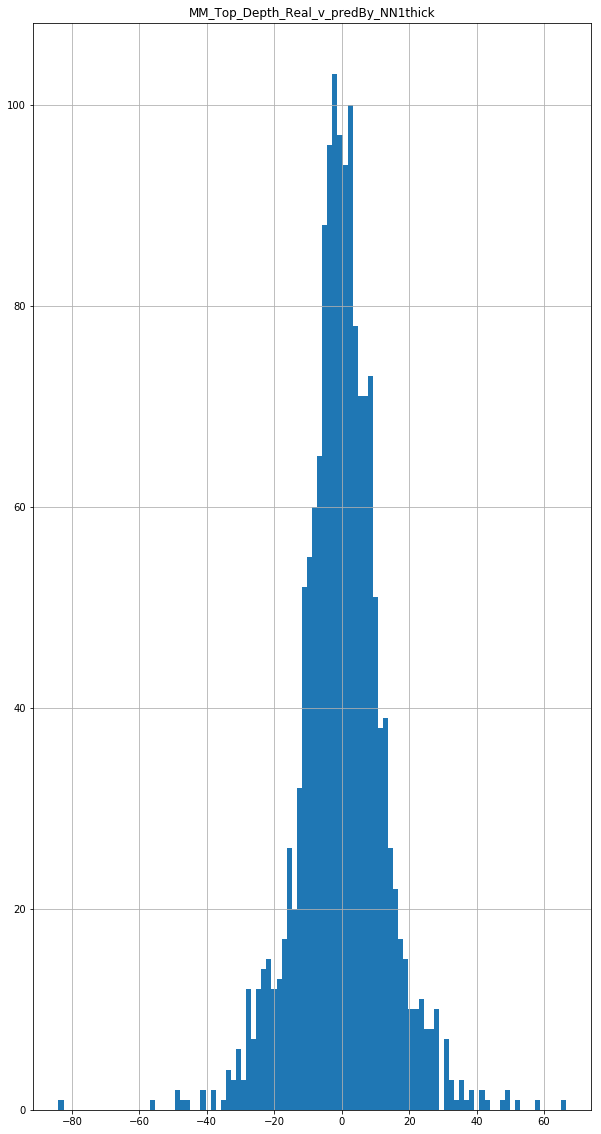

In [76]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786dfbc482b0>]],
      dtype=object)

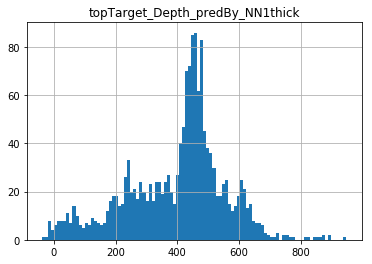

In [77]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
doNotSaveThisDF_temp5.hist(column='topTarget_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786dfba492b0>]],
      dtype=object)

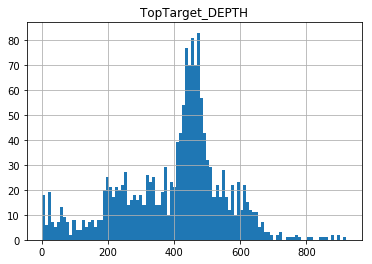

In [78]:
doNotSaveThisDF_temp5.hist(column='TopTarget_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786df883efd0>]],
      dtype=object)

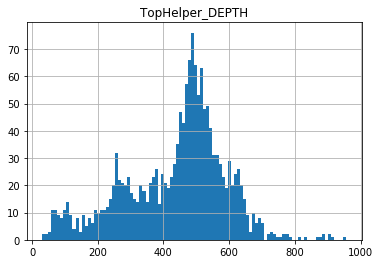

In [79]:
doNotSaveThisDF_temp5.hist(column='TopHelper_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [80]:
df_test = doNotSaveThisDF_temp5.copy()

In [81]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

In [82]:
#### number of rows in each column with zero values
df_test[df_test.NN1_topTarget_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [83]:
df_test[df_test.TopHelper_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

In [84]:
# no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
# no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [85]:
no_zeros_df =df_test.copy()

In [86]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'][0:5]

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

In [87]:
##no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786df872a828>]],
      dtype=object)

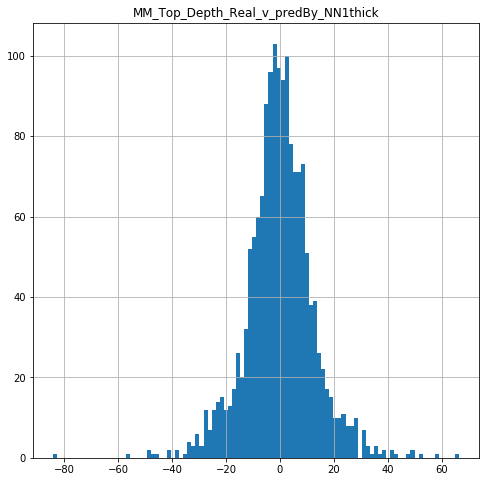

In [88]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [89]:
len(no_zeros_df)

1601

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [90]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [91]:
no_zeros_df_TopDepthVsNNleak

SitID        lat         lng                  UWI  TopHelper_HorID  \
0     102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1     102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2     102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3     102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4     102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   
5     102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
6     102505  54.785901 -110.422131  00/10-08-067-03W4/0            14000   
7     102507  54.800533 -110.345762  00/10-14-067-03W4/0            14000   
8     102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9     102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   
10    102518  54.771451 -110.498414  00/10-02-067-04W4/0            14000   
11    102565  54.785896 -110.599928  00/10-07-067-04W4/0            14000   
12    102577  54.814989 -110.479147  00/11-24-067-04W4/0            14000   
13    102581  54.840482 -110.549109  00/07-33-067-04W4/0            14000   
14    102583  54.775090 -110.688675  00/13-03-067-05W4/0            14000   
15    102589  54.796954 -110.707896  00/06-16-067-05W4/0            14000   
16    102592  54.826012 -110.625318  00/07-25-067-05W4/0            14000   
17    102596  54.844116 -110.701599  00/10-33-067-05W4/0            14000   
18    102597  54.775087 -110.777910  00/15-01-067-06W4/0            14000   
19    102606  54.796947 -110.885862  00/06-17-067-06W4/0            14000   
20    141727  54.811402 -110.803309  00/07-23-067-06W4/0            14000   
21    102609  54.822471 -110.879581  00/02-29-067-06W4/0            14000   
22    102610  54.771468 -111.038407  00/11-05-067-07W4/0            14000   
23    102611  54.796937 -110.936727  00/06-13-067-07W4/0            14000   
24    102614  54.822460 -110.936727  00/03-25-067-07W4/0            14000   
25    102615  54.826041 -111.025865  00/08-29-067-07W4/0            14000   
26    102619  54.771478 -111.133860  00/10-03-067-08W4/0            14000   
27    102620  54.796927 -111.089256  00/06-13-067-08W4/0            14000   
28    141732  54.829658 -111.184726  00/10-29-067-08W4/0            14000   
29    102626  54.840503 -111.133864  00/07-34-067-08W4/0            14000   
30    163611  54.826009 -111.445246  00/06-27-067-10W4/0            14000   
31    163612  54.844056 -111.508948  00/09-31-067-10W4/0            14000   
32    102630  54.764109 -111.674106  00/03-06-067-11W4/0            14000   
33    163614  54.844075 -111.616965  00/10-33-067-11W4/0            14000   
34    141733  54.767736 -111.718675  00/07-02-067-12W4/0            14000   
35    102633  54.767676 -111.788610  00/08-05-067-12W4/0            14000   
36    102640  54.796863 -111.699581  00/06-13-067-12W4/0            14000   
37    141734  54.811292 -111.737853  00/08-22-067-12W4/2            14000   
38    102656  54.771211 -111.902778  00/11-03-067-13W4/0            14000   
39    102666  54.843896 -111.896572  00/10-34-067-13W4/0            14000   
40    102671  54.843897 -111.852009  00/11-36-067-13W4/0            14000   
41    102672  54.767516 -112.055371  00/06-03-067-14W4/0            14000   
42    102679  54.785519 -112.112394  00/12-08-067-14W4/0            14000   
43    102681  54.785555 -112.055334  00/11-10-067-14W4/0            14000   
44    102684  54.803748 -112.137831  00/13-18-067-14W4/0            14000   
45    102686  54.767425 -112.169807  00/08-02-067-15W4/0            14000   
46    141736  54.770993 -112.277768  00/10-06-067-15W4/0            14000   
47    102698  54.814564 -112.207734  00/11-22-067-15W4/0            14000   
48    102702  54.839992 -112.284017  00/06-31-067-15W4/0            14000   
49    102710  54.782042 -112.430364  00/07-07-067-16W4/0            14000   
50    102714  54.785454 -112.309435  00/11-12-067-16W4/0            14000   
51 

In [92]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost20180927_vA__NoMcTopLeak_v3.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [93]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [94]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [95]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [96]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [97]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [98]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[1:3]," and depth is",row[12:13][0], " and UWI is ",row[3:4][0])
    folium.CircleMarker(
    location=row[1:3],
    radius=2,
    color=depth_color(row[13:14][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)


# for row in list_df_for_map[0:]:
#     print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
#     folium.CircleMarker(
#     location=row[7:9],
#     radius=2,
#     color=depth_color(row[15:16][0]),
#     fill=True,
# #     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
# #     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
#     ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 630.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is 613.0  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 613.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is 613.0  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 603.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is 558.0  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is 558.0  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 558.0  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 572.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is 606.5  and UWI is  00/07-36-067-03W4/0
location =  [5

location =  [54.927732999999996, -111.38812800000001]  and depth is 690.07  and UWI is  00/07-36-068-10W4/0
location =  [54.85508299999999, -111.62953799999998]  and depth is 481.0  and UWI is  00/05-04-068-11W4/0
location =  [54.876765, -111.629562]  and depth is 545.0  and UWI is  00/13-09-068-11W4/0
location =  [54.913273, -111.60414499999999]  and depth is 481.0  and UWI is  00/05-27-068-11W4/0
location =  [54.91689, -111.597866]  and depth is 481.0  and UWI is  00/11-27-068-11W4/0
location =  [54.920494, -111.67415600000001]  and depth is 481.0  and UWI is  00/14-30-068-11W4/0
location =  [54.880391, -111.826646]  and depth is 493.78  and UWI is  00/03-18-068-12W4/0
location =  [54.898593000000005, -111.725]  and depth is 493.78  and UWI is  00/06-23-068-12W4/0
location =  [54.916768000000005, -111.80123700000001]  and depth is 486.0  and UWI is  00/11-29-068-12W4/0
location =  [54.927575, -111.82663899999999]  and depth is 486.0  and UWI is  00/06-31-068-12W4/0
location =  [54.85

location =  [55.058615, -112.25256599999999]  and depth is 491.0  and UWI is  00/07-17-070-15W4/0
location =  [55.069453, -112.258853]  and depth is 491.0  and UWI is  00/03-20-070-15W4/0
location =  [55.109595, -112.22083400000001]  and depth is 517.55  and UWI is  00/16-33-070-15W4/0
location =  [55.043944999999994, -112.41141499999999]  and depth is 463.3  and UWI is  00/06-08-070-16W4/0
location =  [55.06218199999999, -112.30341399999999]  and depth is 491.0  and UWI is  00/10-13-070-16W4/0
location =  [55.08765699999999, -112.30968899999999]  and depth is 514.0  and UWI is  00/06-25-070-16W4/0
location =  [55.105799, -112.315874]  and depth is 503.0  and UWI is  00/12-36-070-16W4/0
location =  [55.062178, -112.51309099999999]  and depth is 477.93  and UWI is  00/11-15-070-17W4/0
location =  [55.10578100000001, -112.58939699999999]  and depth is 477.93  and UWI is  00/11-31-070-17W4/0
location =  [55.102109999999996, -112.48142]  and depth is 477.93  and UWI is  00/07-35-070-17W4/0

location =  [55.193659, -112.70842900000001]  and depth is 497.74  and UWI is  00/10-33-071-18W4/0
location =  [55.179152, -112.926309]  and depth is 497.0  and UWI is  00/12-30-071-19W4/0
location =  [55.186426000000004, -112.79799799999999]  and depth is 533.0  and UWI is  00/04-36-071-19W4/0
location =  [55.150071999999994, -112.990573]  and depth is 531.57  and UWI is  00/10-15-071-20W4/0
location =  [55.168123, -112.958624]  and depth is 492.0  and UWI is  00/16-23-071-20W4/0
location =  [55.193630000000006, -112.99686899999999]  and depth is 493.78  and UWI is  00/11-34-071-20W4/0
location =  [55.117231999999994, -113.233851]  and depth is 601.0  and UWI is  00/05-06-071-21W4/0
location =  [55.131826000000004, -113.381231]  and depth is 601.37  and UWI is  00/06-07-071-22W4/0
location =  [55.13183000000001, -113.278779]  and depth is 623.0  and UWI is  00/06-11-071-22W4/0
location =  [55.157331000000006, -113.298073]  and depth is 601.37  and UWI is  00/02-22-071-22W4/0
location 

location =  [55.291938, -110.54787900000001]  and depth is 494.0  and UWI is  00/08-04-073-04W4/0
location =  [55.324622, -110.60564199999999]  and depth is 480.0  and UWI is  00/10-18-073-04W4/0
location =  [55.364551, -110.61198999999999]  and depth is 435.0  and UWI is  00/06-31-073-04W4/0
location =  [55.295543, -110.74043]  and depth is 503.5  and UWI is  00/11-05-073-05W4/0
location =  [55.353705000000005, -110.625]  and depth is 489.0  and UWI is  00/09-25-073-05W4/0
location =  [55.35372099999999, -110.73408700000002]  and depth is 544.0  and UWI is  00/10-29-073-05W4/0
location =  [55.364557999999995, -110.657028]  and depth is 496.0  and UWI is  00/07-35-073-05W4/0
location =  [55.291948, -110.836724]  and depth is 560.0  and UWI is  00/07-03-073-06W4/0
location =  [55.306396, -110.919977]  and depth is 471.0  and UWI is  00/06-07-073-06W4/0
location =  [55.321017000000005, -110.791774]  and depth is 544.0  and UWI is  00/06-13-073-06W4/0
location =  [55.368190000000006, -110

location =  [55.397299, -111.15078500000001]  and depth is 543.0  and UWI is  00/11-10-074-08W4/0
location =  [55.408319999999996, -111.15078500000001]  and depth is 543.0  and UWI is  00/06-15-074-08W4/0
location =  [55.411976, -111.227649]  and depth is 495.5  and UWI is  00/11-18-074-08W4/0
location =  [55.397361, -111.355833]  and depth is 487.68  and UWI is  00/11-08-074-09W4/0
location =  [55.397366000000005, -111.272604]  and depth is 502.0  and UWI is  00/10-11-074-09W4/0
location =  [55.412001000000004, -111.272601]  and depth is 487.68  and UWI is  00/10-14-074-09W4/0
location =  [55.437484999999995, -111.29824099999999]  and depth is 495.5  and UWI is  00/07-27-074-09W4/0
location =  [55.397302, -111.515965]  and depth is 509.0  and UWI is  00/12-08-074-10W4/0
location =  [55.455459999999995, -111.445775]  and depth is 482.0  and UWI is  00/09-34-074-10W4/0
location =  [55.39368399999999, -111.663568]  and depth is 522.0  and UWI is  00/06-08-074-11W4/0
location =  [55.39730

location =  [55.513501, -113.385764]  and depth is 640.08  and UWI is  00/11-20-075-22W4/0
location =  [55.524522999999995, -113.301749]  and depth is 647.4  and UWI is  00/07-26-075-22W4/0
location =  [55.542595999999996, -113.35349599999999]  and depth is 609.6  and UWI is  00/10-33-075-22W4/0
location =  [55.462816000000004, -113.502398]  and depth is 690.0  and UWI is  00/01-04-075-23W4/0
location =  [55.477211, -113.51518]  and depth is 690.0  and UWI is  00/03-09-075-23W4/0
location =  [55.499053, -113.56694399999999]  and depth is 618.74  and UWI is  00/11-18-075-23W4/0
location =  [55.538971, -113.43113400000001]  and depth is 594.36  and UWI is  00/07-36-075-23W4/0
location =  [55.466395999999996, -113.61231599999999]  and depth is 581.56  and UWI is  00/07-02-075-24W4/0
location =  [55.4664, -113.670473]  and depth is 643.0  and UWI is  00/06-04-075-24W4/0
location =  [55.506278, -113.580044]  and depth is 618.74  and UWI is  00/01-24-075-24W4/0
location =  [55.466391, -113.8

location =  [55.658995, -110.92753]  and depth is 369.0  and UWI is  00/11-07-077-06W4/0
location =  [55.66999200000001, -110.791725]  and depth is 400.0  and UWI is  00/07-13-077-06W4/0
location =  [55.670018999999996, -110.875759]  and depth is 360.0  and UWI is  00/06-16-077-06W4/0
location =  [55.699079000000005, -110.791724]  and depth is 400.0  and UWI is  00/07-25-077-06W4/0
location =  [55.644553, -111.024658]  and depth is 374.5  and UWI is  00/10-04-077-07W4/0
location =  [55.644535999999995, -111.082807]  and depth is 375.5  and UWI is  00/11-06-077-07W4/0
location =  [55.688123, -111.03106000000001]  and depth is 364.0  and UWI is  00/11-21-077-07W4/0
location =  [55.702760999999995, -111.050555]  and depth is 364.0  and UWI is  00/10-29-077-07W4/0
location =  [55.644549, -111.134574]  and depth is 361.5  and UWI is  00/11-02-077-08W4/0
location =  [55.65900799999999, -111.12817700000001]  and depth is 361.5  and UWI is  AA/10-11-077-08W4/0
location =  [55.65176999999999, -

location =  [55.80081800000001, -112.738872]  and depth is 365.15  and UWI is  00/06-33-078-18W4/0
location =  [55.786341, -112.842408]  and depth is 391.5  and UWI is  00/06-26-078-19W4/0
location =  [55.786333, -112.926327]  and depth is 389.0  and UWI is  00/05-29-078-19W4/0
location =  [55.804365000000004, -113.19824399999999]  and depth is 415.0  and UWI is  00/10-33-078-21W4/0
location =  [55.804356999999996, -113.12700500000001]  and depth is 428.5  and UWI is  00/11-36-078-21W4/0
location =  [55.804347, -113.28226599999999]  and depth is 429.5  and UWI is  00/11-36-078-22W4/0
location =  [55.742596999999996, -113.560556]  and depth is 524.0  and UWI is  00/07-07-078-23W4/0
location =  [55.742612, -113.508793]  and depth is 480.36  and UWI is  00/07-09-078-23W4/0
location =  [55.77530600000001, -113.457022]  and depth is 524.0  and UWI is  00/10-23-078-23W4/0
location =  [55.782743, -113.57325700000001]  and depth is 520.6  and UWI is  00/04-30-078-23W4/0
location =  [55.804375,

location =  [55.949783999999994, -112.155694]  and depth is 382.0  and UWI is  00/10-20-080-14W4/0
location =  [55.964418, -112.077389]  and depth is 488.5  and UWI is  AA/10-26-080-14W4/0
location =  [55.957240000000006, -112.097043]  and depth is 488.5  and UWI is  00/01-27-080-14W4/0
location =  [55.906243, -112.31231399999999]  and depth is 444.4  and UWI is  00/10-05-080-15W4/0
location =  [55.920694, -112.234003]  and depth is 444.4  and UWI is  AA/10-11-080-15W4/0
location =  [55.935327, -112.31876100000001]  and depth is 384.0  and UWI is  00/11-17-080-15W4/0
location =  [55.920683, -112.37096799999999]  and depth is 386.5  and UWI is  00/11-12-080-16W4/0
location =  [55.935304, -112.495061]  and depth is 364.0  and UWI is  00/10-18-080-16W4/0
location =  [55.964413, -112.397074]  and depth is 384.0  and UWI is  00/11-26-080-16W4/0
location =  [55.964406999999994, -112.47539099999999]  and depth is 364.0  and UWI is  00/11-29-080-16W4/0
location =  [55.96441899999999, -112.6058

location =  [56.033376000000004, -113.330294]  and depth is 429.5  and UWI is  00/07-23-081-22W4/0
location =  [55.989833999999995, -113.473619]  and depth is 444.0  and UWI is  00/05-01-081-23W4/0
location =  [56.000676, -113.473623]  and depth is 454.0  and UWI is  00/04-12-081-23W4/0
location =  [56.01893199999999, -113.51301799999999]  and depth is 454.0  and UWI is  00/07-15-081-23W4/0
location =  [56.03337, -113.467257]  and depth is 457.0  and UWI is  00/06-24-081-23W4/0
location =  [56.007897, -113.747895]  and depth is 464.0  and UWI is  00/10-07-081-24W4/0
location =  [56.026151, -113.72823700000001]  and depth is 452.32  and UWI is  00/14-17-081-24W4/0
location =  [56.033377, -113.728232]  and depth is 452.32  and UWI is  00/06-20-081-24W4/0
location =  [56.036995999999995, -113.69571200000001]  and depth is 458.0  and UWI is  00/10-21-081-24W4/0
location =  [56.007904, -113.832646]  and depth is 454.46  and UWI is  00/11-10-081-25W4/0
location =  [56.007892000000005, -113.7

location =  [56.266279000000004, -110.60162700000001]  and depth is 291.0  and UWI is  00/06-08-084-04W4/0
location =  [56.298977, -110.60162700000001]  and depth is 223.0  and UWI is  00/11-20-084-04W4/0
location =  [56.328064000000005, -110.595124]  and depth is 223.0  and UWI is  00/10-32-084-04W4/0
location =  [56.255438, -110.76622900000001]  and depth is 340.16  and UWI is  00/12-05-084-05W4/0
location =  [56.295365000000004, -110.759708]  and depth is 314.0  and UWI is  00/06-20-084-05W4/0
location =  [56.328068, -110.746696]  and depth is 256.5  and UWI is  00/09-32-084-05W4/0
location =  [56.328062, -110.67416000000001]  and depth is 230.0  and UWI is  00/10-35-084-05W4/0
location =  [56.251822, -110.917774]  and depth is 359.0  and UWI is  00/06-05-084-06W4/0
location =  [56.298961, -110.81241399999999]  and depth is 355.0  and UWI is  00/11-24-084-06W4/0
location =  [56.313614, -110.91128799999998]  and depth is 346.0  and UWI is  00/10-29-084-06W4/0
location =  [56.328065, 

location =  [56.677, -112.60045900000001]  and depth is 261.5  and UWI is  00/11-35-088-17W4/0
location =  [56.607986, -112.806601]  and depth is 236.0  and UWI is  00/15-04-088-18W4/0
location =  [56.644279000000004, -112.859765]  and depth is 227.5  and UWI is  00/07-19-088-18W4/0
location =  [56.644293999999995, -112.78000800000001]  and depth is 197.5  and UWI is  00/07-22-088-18W4/0
location =  [56.676979, -112.7334]  and depth is 211.0  and UWI is  00/11-36-088-18W4/0
location =  [56.604369999999996, -112.992682]  and depth is 268.83  and UWI is  AA/10-05-088-19W4/0
location =  [56.615207, -112.91293]  and depth is 257.0  and UWI is  AA/07-11-088-19W4/0
location =  [56.658927, -112.9661]  and depth is 257.0  and UWI is  AA/07-28-088-19W4/0
location =  [56.676974, -113.01926999999999]  and depth is 257.0  and UWI is  AA/10-31-088-19W4/0
location =  [56.62984399999999, -113.125607]  and depth is 268.83  and UWI is  AA/07-16-088-20W4/0
location =  [56.604372999999995, -113.291679]  

location =  [57.200708999999996, -110.907776]  and depth is 294.5  and UWI is  AA/11-33-094-06W4/0
location =  [57.164412, -111.02163600000002]  and depth is 227.0  and UWI is  AA/04-23-094-07W4/0
location =  [57.186265, -111.088954]  and depth is 259.0  and UWI is  AA/10-29-094-07W4/0
location =  [57.186254000000005, -111.11578300000001]  and depth is 128.0  and UWI is  AA/10-30-094-07W4/0
location =  [57.157194, -111.20286899999999]  and depth is 99.0  and UWI is  AB/11-15-094-08W4/0
location =  [57.17525, -111.256505]  and depth is 128.0  and UWI is  AA/14-20-094-08W4/0
location =  [57.189888, -111.20286599999999]  and depth is 99.0  and UWI is  AA/14-27-094-08W4/0
location =  [57.193488, -111.27008000000001]  and depth is 136.0  and UWI is  AA/01-31-094-08W4/0
location =  [57.1971, -111.31668799999998]  and depth is 99.0  and UWI is  AA/05-36-094-09W4/0
location =  [57.128114000000004, -111.772749]  and depth is 108.5  and UWI is  AB/12-06-094-11W4/0
location =  [57.13896, -111.652

location =  [57.73161700000001, -112.088545]  and depth is 547.5  and UWI is  AA/01-05-101-13W4/0
location =  [57.771529, -112.013236]  and depth is 575.5  and UWI is  AA/15-14-101-13W4/0
location =  [57.796999, -112.04735]  and depth is 546.5  and UWI is  AA/11-27-101-13W4/0
location =  [57.796978, -112.129423]  and depth is 546.5  and UWI is  AA/11-30-101-13W4/0
location =  [57.753273, -112.266195]  and depth is 477.0  and UWI is  AA/11-08-101-14W4/0
location =  [57.793366000000006, -112.266201]  and depth is 584.0  and UWI is  AA/06-29-101-14W4/0
location =  [57.80781700000001, -112.18413899999999]  and depth is 538.0  and UWI is  AA/06-35-101-14W4/0


In [99]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [100]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

## Lets now look at the distribution of the difference between target depth and depth predicted just from nearest neighbor

In [101]:
no_zeros_df_TopDepthVsNN = no_zeros_df.copy()

In [102]:
no_zeros_df_TopDepthVsNN.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  0.0  
1                            520.5                                 -5.5  
2                            480.0                                  0.0  
3                            552.5                                 -3.5  
4                            524.0                                  5.0

In [103]:
def error_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 80:
            color = 'black'
        elif depth >= 30 and depth < 60:
            color = 'orange'
        elif depth > 5 and depth < 30:
            color = 'yellow'
        elif depth >= -5 and depth <= 5:
            color = 'green'
        elif depth >= -30 and depth < -5:
            color = 'brown'
        elif depth >= -60 and depth < -30:
            color = 'purple'
        else:
            color = 'pink'
    return color

In [104]:
def makeMap(centerLatLongArray,tilesStr,zoom_startInt,radiusInt,df):
    m7 = folium.Map(centerLatLongArray, tiles=tilesStr, zoom_start=zoom_startInt)
    list_df_for_map = df.values.tolist()

    for row in list_df_for_map[0:]:
        #print("location = ",row[1:3]," and depth is",row[12:13][0], " and UWI is ",row[3:4][0])
        folium.CircleMarker(
        location=row[1:3],
        radius=radiusInt,
        color=error_color(row[15:16][0]),
        fill=True,
         #popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
         popup=folium.Popup((str(row[1:3])+ ", error in Top Target="+str(row[15:16][0])), parse_html=True)
        ).add_to(m7)
    return m7


In [105]:
m7 = makeMap([54.840471, -110.269399],'Stamen Toner',6,2,no_zeros_df_TopDepthVsNN)

In [106]:
m7

# Now we'll do that same things as above but only for the train rows!

In [107]:
no_zeros_df.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  0.0  
1                            520.5                                 -5.5  
2                            480.0                                  0.0  
3                            552.5                                 -3.5  
4                            524.0                                  5.0

## Import df with train/test split column

In [115]:
# h5_filename_df_wells_wTrainTestSplitCol = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')

In [116]:
wellsLoaded_df_fromh5.head()

CALI  COND  DELT     DEPT   DPHI  DT      GR     ILD  ILM   NPHI  PHID  \
0  6.348   NaN   NaN  600.000  0.209 NaN  68.666  16.993  NaN  0.598   NaN   
1  6.347   NaN   NaN  600.820  0.239 NaN  71.094  17.622  NaN  0.598   NaN   
2  6.344   NaN   NaN  601.640  0.240 NaN  71.667  23.241  NaN  0.597   NaN   
3  6.341   NaN   NaN  602.461  0.247 NaN  71.029  27.422  NaN  0.594   NaN   
4  6.340   NaN   NaN  603.281  0.251 NaN  68.528  24.072  NaN  0.588   NaN   

   RHOB  SFL  SFLU  SN  SP                      UWI trainOrTest  
0   NaN  NaN   NaN NaN NaN  00-10-16-092-19W4-0.LAS       train  
1   NaN  NaN   NaN NaN NaN  00-10-16-092-19W4-0.LAS       train  
2   NaN  NaN   NaN NaN NaN  00-10-16-092-19W4-0.LAS       train  
3   NaN  NaN   NaN NaN NaN  00-10-16-092-19W4-0.LAS       train  
4   NaN  NaN   NaN NaN NaN  00-10-16-092-19W4-0.LAS       train

In [119]:
def changeUWIcol(df,colName):
    #df['a'] = df['a'].apply(lambda x: x + 1)
    df[colName] = df[colName].apply(lambda x: changeLASfileToBeUWIstr(x))
    return df

In [120]:
wellsLoaded_df_fromh5_newUWI = changeUWIcol(wellsLoaded_df_fromh5,'UWI')

### Now lets only keep the train wells

In [122]:
wells_train_only = wellsLoaded_df_fromh5_newUWI.loc[wellsLoaded_df_fromh5_newUWI['trainOrTest'] == 'train']

In [140]:
wells_train_only.head()

CALI  COND  DELT     DEPT   DPHI  DT      GR     ILD  ILM   NPHI  PHID  \
0  6.348   NaN   NaN  600.000  0.209 NaN  68.666  16.993  NaN  0.598   NaN   
1  6.347   NaN   NaN  600.820  0.239 NaN  71.094  17.622  NaN  0.598   NaN   
2  6.344   NaN   NaN  601.640  0.240 NaN  71.667  23.241  NaN  0.597   NaN   
3  6.341   NaN   NaN  602.461  0.247 NaN  71.029  27.422  NaN  0.594   NaN   
4  6.340   NaN   NaN  603.281  0.251 NaN  68.528  24.072  NaN  0.588   NaN   

   RHOB  SFL  SFLU  SN  SP                  UWI trainOrTest  
0   NaN  NaN   NaN NaN NaN  00/10-16-092-19W4/0       train  
1   NaN  NaN   NaN NaN NaN  00/10-16-092-19W4/0       train  
2   NaN  NaN   NaN NaN NaN  00/10-16-092-19W4/0       train  
3   NaN  NaN   NaN NaN NaN  00/10-16-092-19W4/0       train  
4   NaN  NaN   NaN NaN NaN  00/10-16-092-19W4/0       train

In [208]:
len(wells_train_only)

1041714

In [124]:
len(wells_train_only['UWI'].unique())

1280

## Okay, now let's do the nearest neighbor process with only the train wells!

In [163]:
# def useThicknessOfNeighborsToEst_TRAIN(df_new2):
#     df_new2['NN1_topTarget_DEPTH_train'] = df_new2['NN1_topTarget_DEPTH_train'].apply(convertStringToFloat)
#     df_new2['NN1_TopHelper_DEPTH_train'] = df_new2['NN1_TopHelper_DEPTH_train'].apply(convertStringToFloat)
#     df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
#     df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
#     df_new2['NN1_thickness_train'] = df_new2['NN1_TopHelper_DEPTH_train'] - df_new2['NN1_topTarget_DEPTH_train']
#     df_new2['topTarget_Depth_predBy_NN1thick_train'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness_train'] 
#     return df_new2

def useThicknessOfNeighborsToEst_TRAIN(df_new2):
    df_new2['NN1_topTarget_DEPTH'] = df_new2['NN1_topTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_TopHelper_DEPTH'] = df_new2['NN1_TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_thickness'] = df_new2['NN1_TopHelper_DEPTH'] - df_new2['NN1_topTarget_DEPTH']
    df_new2['topTarget_Depth_predBy_NN1thick'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness'] 
    return df_new2

In [164]:
def makeKNearNeighObj_train(df_new,KDtree,numberNeighbors):
    #### Takes in 
    #### Returns 
    
    ##### first part......
    #### make a data frame of UWI & index from main dataframe
    UWIs = df_new[['UWI']]
    position = df_new[['lat','lng']]
    #UWIs.join(position, how='outer') 
    UWIs_Geog = pd.concat([UWIs, position], axis=1)
    #print(UWIs_Geog.head())
    #### Add object of tree for 8 neighbors to a dataframe
    latlng_kd_tree_leaf2 = KDtree
    #### Finding 8 nearest neighbors based on lat/long
    #### K is number of neighbors
    dist, ind = latlng_kd_tree_leaf2.query([position][0], k=numberNeighbors) 
    neighbor_array_per_well_row = []
    #### for i in ind.length
    for i in range(len(ind)):
        #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
        neighbors_ind = ind[i][1:]
        # for each index in that array, 
        counter = 1
        array_of_holder_obj = []
        for n in neighbors_ind:
            #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
            holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
            #### get the distance into the temp object using index of i and each,
            holder_obj['distance'] = dist[i][counter]
            #### get the UWI using i and the dataframe
            holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
            #### and position via "counter"
            holder_obj['neighbor'] = counter
            #### add the temp object populated as a column entry into an array
            counter = counter + 1
            array_of_holder_obj.append(holder_obj)
        #### turn array of objects into series and add as new column to dataframe
        neighbor_array_per_well_row.append(array_of_holder_obj)
    UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)
    return UWIs_Geog

In [242]:
def bigFunctionNearestNeighbor(df_geo,df_wells_train,wells_train_list, picks_dic,picks,wells,gis):
    df_new = pd.merge(wells, picks_targetTop, on='SitID')
    df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
    df_gis = pd.merge(df_paleoz, gis, on='SitID')
    df_new=pd.merge(df_gis, df_new, on='SitID')
    
    #### find list of wells , returns a list of well names
#     wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
    #wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')
    new_wells_loaded_list_inUWIstyle =list(df_wells_train['UWI'].unique())
    
#     new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)
    print(type(new_wells_loaded_list_inUWIstyle))
    print(len(new_wells_loaded_list_inUWIstyle))
    #### gets a tops and geography dataframe that only has those wells in the list above
    df = df_new[df_new['UWI'].isin(wells_train_list)]
    print("len df",len(df))
    print("got to first df")
    print(len(df['UWI'].unique()))
    #### reset index here but know that we'll have to remap to merge with nearest neighbor columns that were done on both train/test datasets
    df = df.reset_index(drop=True)
    #### this is the nearest neighbors part
    print("got into start of NN")
    position_forTrain = df[['lat','lng']]
    tree_forTrain = neighbors.KDTree(position_forTrain, leaf_size=2)
    dist_forTrain, ind_forTrain = tree_forTrain.query([position_forTrain][0], k=8) 
    #### get df with UWIs, lat/long, and basic nearest neighbor columns
    print('got to above UWIs_Geog')
    UWIs_Geog = makeKNearNeighObj_train(df,tree_forTrain,8)
    print("got here >")
    print(len(UWIs_Geog),"len(UWIs_Geog)")
    #### clean the dataframe to only the stuff with need
    df_new_cleaned = cleanRenameDF(df,13000,14000)
    print(len( df_new_cleaned),"len( df_new_cleaned)")
    df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)
    print("got to above temp2")
    temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH')
    df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH')
    df_new2 = useThicknessOfNeighborsToEst_TRAIN(df_new2)
    doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  df_new2['TopTarget_DEPTH'] - df_new2['topTarget_Depth_predBy_NN1thick']
    return doNotSaveThisDF_temp5


# def bigFunctionNearestNeighbor(df_geo,df_wells_train, picks_dic,picks,wells,gis):
#     df_new = pd.merge(wells, picks_targetTop, on='SitID')
#     df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
#     df_gis = pd.merge(df_paleoz, gis, on='SitID')
#     df_new=pd.merge(df_gis, df_new, on='SitID')
    
#     #### find list of wells , returns a list of well names
# #     wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
#     wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')
#     new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)
#     print(type(new_wells_loaded_list_inUWIstyle))
#     #### gets a tops and geography dataframe that only has those wells in the list above
#     df = df_new[df_new['UWI'].isin(new_wells_loaded_list_inUWIstyle)]
#     print("got to first df")
#     #### reset index here but know that we'll have to remap to merge with nearest neighbor columns that were done on both train/test datasets
#     df = df.reset_index(drop=True)
#     #### this is the nearest neighbors part
#     print("got into start of NN")
#     position_forTrain = df[['lat','lng']]
#     tree_forTrain = neighbors.KDTree(position_forTrain, leaf_size=2)
#     dist_forTrain, ind_forTrain = tree_forTrain.query([position][0], k=8) 
#     #### get df with UWIs, lat/long, and basic nearest neighbor columns
#     print('got to above UWIs_Geog')
#     UWIs_Geog = makeKNearNeighObj_train(df,tree_forTrain,8)
#     print("got here >")
#     #### clean the dataframe to only the stuff with need
#     df_new_cleaned = cleanRenameDF(df,13000,14000)
#     df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)
#     print("got to above temp2")
#     temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH_train')
#     df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH_train')
#     df_new2 = useThicknessOfNeighborsToEst_TRAIN(df_new2)
#     doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick_train'] =  df_new2['TopTarget_DEPTH'] - df_new2['topTarget_Depth_predBy_NN1thick_train']
#     return doNotSaveThisDF_temp5

In [243]:
len(wells_train_only['UWI'].unique())

1280

In [244]:
testA = bigFunctionNearestNeighbor(df_new,wells_train_only,wells_train_only['UWI'].unique(),picks_dic,picks,wells,gis)

<class 'list'>
1280
len df 1280
got to first df
1280
got into start of NN
got to above UWIs_Geog
got here >
1280 len(UWIs_Geog)
1280 len( df_new_cleaned)
got to above temp2
0   NaN
Name: NN1_topTarget_DEPTH, dtype: float64
len(df) 1280
0
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  44
pick_depth  514


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


len(df) 1280
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  2
pick_depth  529
len(df) 1280
2
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  44
pick_depth  514
len(df) 1280
3
<class 'str'> type to right of  00/09-05-068-03W4/0
index_of_neigh_UWI=  47
pick_depth  507.5
len(df) 1280
4
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  5
pick_depth  493.5
len(df) 1280
5
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  3
pick_depth  501.5
len(df) 1280
6
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  4
pick_depth  553.5
len(df) 1280
7
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  9
pick_depth  509
len(df) 1280
8
<class 'str'> type to right of  00/07-12-068-05W4/0
index_of_neigh_UWI=  55
pick_depth  494
len(df) 1280
9
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  51
pick_depth  511
len(df) 1280
10
<class 'str'> type

index_of_neigh_UWI=  39
pick_depth  534.62
len(df) 1280
79
<class 'str'> type to right of  00/11-10-068-18W4/0
index_of_neigh_UWI=  82
pick_depth  485
len(df) 1280
80
<class 'str'> type to right of  00/06-27-068-18W4/0
index_of_neigh_UWI=  83
pick_depth  486.16
len(df) 1280
81
<class 'str'> type to right of  00/06-27-068-18W4/0
index_of_neigh_UWI=  83
pick_depth  486.16
len(df) 1280
82
<class 'str'> type to right of  00/06-27-068-18W4/0
index_of_neigh_UWI=  83
pick_depth  486.16
len(df) 1280
83
<class 'str'> type to right of  00/10-10-069-18W4/0
index_of_neigh_UWI=  127
pick_depth  473.05
len(df) 1280
84
<class 'str'> type to right of  00/10-10-069-18W4/0
index_of_neigh_UWI=  127
pick_depth  473.05
len(df) 1280
85
<class 'str'> type to right of  00/06-13-068-03W4/0
index_of_neigh_UWI=  48
pick_depth  546
len(df) 1280
86
<class 'str'> type to right of  00/06-19-069-04W4/0
index_of_neigh_UWI=  88
pick_depth  483
len(df) 1280
87
<class 'str'> type to right of  00/05-04-069-04W4/0
index_of

index_of_neigh_UWI=  220
pick_depth  506.58
len(df) 1280
155
<class 'str'> type to right of  00/07-17-070-15W4/0
index_of_neigh_UWI=  156
pick_depth  455.5
len(df) 1280
156
<class 'str'> type to right of  00/11-06-070-15W4/0
index_of_neigh_UWI=  155
pick_depth  455
len(df) 1280
157
<class 'str'> type to right of  00/11-06-070-15W4/0
index_of_neigh_UWI=  155
pick_depth  455
len(df) 1280
158
<class 'str'> type to right of  00/03-20-070-15W4/0
index_of_neigh_UWI=  157
pick_depth  449
len(df) 1280
159
<class 'str'> type to right of  00/07-35-070-17W4/0
index_of_neigh_UWI=  165
pick_depth  456
len(df) 1280
160
<class 'str'> type to right of  00/11-06-070-15W4/0
index_of_neigh_UWI=  155
pick_depth  455
len(df) 1280
161
<class 'str'> type to right of  00/10-13-070-16W4/0
index_of_neigh_UWI=  160
pick_depth  462
len(df) 1280
162
<class 'str'> type to right of  00/10-13-070-16W4/0
index_of_neigh_UWI=  160
pick_depth  462
len(df) 1280
163
<class 'str'> type to right of  00/06-03-071-17W4/0
index

len(df) 1280
230
<class 'str'> type to right of  00/10-33-071-18W4/0
index_of_neigh_UWI=  229
pick_depth  474.27
len(df) 1280
231
<class 'str'> type to right of  00/11-06-072-19W4/0
index_of_neigh_UWI=  297
pick_depth  480.36
len(df) 1280
232
<class 'str'> type to right of  00/02-22-071-22W4/0
index_of_neigh_UWI=  235
pick_depth  593.5
len(df) 1280
233
<class 'str'> type to right of  00/06-29-071-22W4/0
index_of_neigh_UWI=  236
pick_depth  591.62
len(df) 1280
234
<class 'str'> type to right of  00/05-06-071-21W4/0
index_of_neigh_UWI=  232
pick_depth  614
len(df) 1280
235
<class 'str'> type to right of  00/06-29-071-22W4/0
index_of_neigh_UWI=  236
pick_depth  591.62
len(df) 1280
236
<class 'str'> type to right of  00/06-07-071-22W4/0
index_of_neigh_UWI=  233
pick_depth  609.6
len(df) 1280
237
<class 'str'> type to right of  00/06-29-071-22W4/0
index_of_neigh_UWI=  236
pick_depth  591.62
len(df) 1280
238
<class 'str'> type to right of  00/11-21-071-24W4/0
index_of_neigh_UWI=  239
pick_de

<class 'str'> type to right of  00/07-30-072-24W4/0
index_of_neigh_UWI=  309
pick_depth  593.75
len(df) 1280
309
<class 'str'> type to right of  00/07-08-072-24W4/0
index_of_neigh_UWI=  308
pick_depth  525.48
len(df) 1280
310
<class 'str'> type to right of  00/16-12-073-25W4/0
index_of_neigh_UWI=  375
pick_depth  578
len(df) 1280
311
<class 'str'> type to right of  00/06-21-071-25W4/0
index_of_neigh_UWI=  243
pick_depth  601.07
len(df) 1280
312
<class 'str'> type to right of  00/16-12-073-25W4/0
index_of_neigh_UWI=  375
pick_depth  578
len(df) 1280
313
<class 'str'> type to right of  00/06-29-071-01W5/0
index_of_neigh_UWI=  248
pick_depth  605.33
len(df) 1280
314
<class 'str'> type to right of  00/11-03-072-01W5/0
index_of_neigh_UWI=  313
pick_depth  644.04
len(df) 1280
315
<class 'str'> type to right of  00/11-03-072-01W5/0
index_of_neigh_UWI=  313
pick_depth  644.04
len(df) 1280
316
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  250
pick_depth  612.65
len(df

len(df) 1280
383
<class 'str'> type to right of  00/08-05-073-02W5/0
index_of_neigh_UWI=  379
pick_depth  589
len(df) 1280
384
<class 'str'> type to right of  00/02-01-074-05W5/0
index_of_neigh_UWI=  457
pick_depth  591
len(df) 1280
385
<class 'str'> type to right of  00/02-01-074-05W5/0
index_of_neigh_UWI=  457
pick_depth  591
len(df) 1280
386
<class 'str'> type to right of  00/02-26-073-05W5/0
index_of_neigh_UWI=  387
pick_depth  580
len(df) 1280
387
<class 'str'> type to right of  00/16-29-073-05W5/0
index_of_neigh_UWI=  388
pick_depth  591.5
len(df) 1280
388
<class 'str'> type to right of  00/02-26-073-05W5/0
index_of_neigh_UWI=  387
pick_depth  580
len(df) 1280
389
<class 'str'> type to right of  00/16-36-072-01W4/0
index_of_neigh_UWI=  254
pick_depth  475
len(df) 1280
390
<class 'str'> type to right of  00/08-24-076-02W4/0
index_of_neigh_UWI=  514
pick_depth  403.56
len(df) 1280
391
<class 'str'> type to right of  00/03-31-075-03W4/0
index_of_neigh_UWI=  459
pick_depth  416
len(d

index_of_neigh_UWI=  467
pick_depth  393
len(df) 1280
467
<class 'str'> type to right of  00/11-04-075-06W4/0
index_of_neigh_UWI=  465
pick_depth  420
len(df) 1280
468
<class 'str'> type to right of  00/11-08-075-05W4/0
index_of_neigh_UWI=  462
pick_depth  406
len(df) 1280
469
<class 'str'> type to right of  00/10-09-074-07W4/0
index_of_neigh_UWI=  403
pick_depth  472.44
len(df) 1280
470
<class 'str'> type to right of  00/11-31-074-06W4/0
index_of_neigh_UWI=  402
pick_depth  403
len(df) 1280
471
<class 'str'> type to right of  00/10-34-075-07W4/0
index_of_neigh_UWI=  472
pick_depth  396.24
len(df) 1280
472
<class 'str'> type to right of  AA/06-14-076-07W4/0
index_of_neigh_UWI=  526
pick_depth  373.5
len(df) 1280
473
<class 'str'> type to right of  00/12-14-075-08W4/0
index_of_neigh_UWI=  474
pick_depth  444.65
len(df) 1280
474
<class 'str'> type to right of  00/10-29-075-08W4/0
index_of_neigh_UWI=  475
pick_depth  460.86
len(df) 1280
475
<class 'str'> type to right of  00/12-14-075-08W

553
<class 'str'> type to right of  00/10-11-077-16W4/0
index_of_neigh_UWI=  613
pick_depth  515
len(df) 1280
554
<class 'str'> type to right of  00/07-19-077-16W4/0
index_of_neigh_UWI=  614
pick_depth  435
len(df) 1280
555
<class 'str'> type to right of  00/06-28-076-17W4/0
index_of_neigh_UWI=  556
pick_depth  517
len(df) 1280
556
<class 'str'> type to right of  00/11-27-076-17W4/0
index_of_neigh_UWI=  555
pick_depth  538.89
len(df) 1280
557
<class 'str'> type to right of  00/11-27-076-17W4/0
index_of_neigh_UWI=  555
pick_depth  538.89
len(df) 1280
558
<class 'str'> type to right of  00/10-06-076-20W4/0
index_of_neigh_UWI=  559
pick_depth  504.14
len(df) 1280
559
<class 'str'> type to right of  00/08-26-076-21W4/0
index_of_neigh_UWI=  560
pick_depth  574
len(df) 1280
560
<class 'str'> type to right of  00/11-03-077-21W4/0
index_of_neigh_UWI=  618
pick_depth  598.02
len(df) 1280
561
<class 'str'> type to right of  00/11-03-077-21W4/0
index_of_neigh_UWI=  618
pick_depth  598.02
len(df) 

index_of_neigh_UWI=  570
pick_depth  721
len(df) 1280
629
<class 'str'> type to right of  00/07-16-077-04W5/0
index_of_neigh_UWI=  633
pick_depth  621.18
len(df) 1280
630
<class 'str'> type to right of  00/07-09-077-04W5/0
index_of_neigh_UWI=  631
pick_depth  640.69
len(df) 1280
631
<class 'str'> type to right of  00/07-16-077-04W5/0
index_of_neigh_UWI=  633
pick_depth  621.18
len(df) 1280
632
<class 'str'> type to right of  00/10-18-076-03W5/0
index_of_neigh_UWI=  571
pick_depth  782
len(df) 1280
633
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  630
pick_depth  650.14
len(df) 1280
634
<class 'str'> type to right of  00/05-19-079-02W4/0
index_of_neigh_UWI=  695
pick_depth  264
len(df) 1280
635
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  637
pick_depth  298
len(df) 1280
636
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  637
pick_depth  298
len(df) 1280
637
<class 'str'> type to right of  00/07-06-079-03W4/

index_of_neigh_UWI=  703
pick_depth  225
len(df) 1280
703
<class 'str'> type to right of  00/08-09-079-05W4/0
index_of_neigh_UWI=  702
pick_depth  252
len(df) 1280
704
<class 'str'> type to right of  00/06-12-079-06W4/0
index_of_neigh_UWI=  706
pick_depth  219
len(df) 1280
705
<class 'str'> type to right of  00/11-28-079-06W4/0
index_of_neigh_UWI=  707
pick_depth  251
len(df) 1280
706
<class 'str'> type to right of  00/12-20-079-05W4/0
index_of_neigh_UWI=  703
pick_depth  225
len(df) 1280
707
<class 'str'> type to right of  00/07-06-080-06W4/0
index_of_neigh_UWI=  767
pick_depth  291
len(df) 1280
708
<class 'str'> type to right of  00/07-06-080-06W4/0
index_of_neigh_UWI=  767
pick_depth  291
len(df) 1280
709
<class 'str'> type to right of  00/10-25-079-07W4/0
index_of_neigh_UWI=  710
pick_depth  297
len(df) 1280
710
<class 'str'> type to right of  00/06-02-080-07W4/0
index_of_neigh_UWI=  770
pick_depth  309
len(df) 1280
711
<class 'str'> type to right of  AA/10-36-079-09W4/0
index_of_n

len(df) 1280
781
<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_neigh_UWI=  783
pick_depth  429
len(df) 1280
782
<class 'str'> type to right of  00/08-02-080-13W4/0
index_of_neigh_UWI=  785
pick_depth  437.5
len(df) 1280
783
<class 'str'> type to right of  00/06-03-080-12W4/0
index_of_neigh_UWI=  781
pick_depth  434
len(df) 1280
784
<class 'str'> type to right of  00/14-01-081-12W4/0
index_of_neigh_UWI=  841
pick_depth  437
len(df) 1280
785
<class 'str'> type to right of  00/01-09-080-13W4/0
index_of_neigh_UWI=  786
pick_depth  441
len(df) 1280
786
<class 'str'> type to right of  00/02-29-080-13W4/0
index_of_neigh_UWI=  787
pick_depth  450
len(df) 1280
787
<class 'str'> type to right of  00/01-09-080-13W4/0
index_of_neigh_UWI=  786
pick_depth  441
len(df) 1280
788
<class 'str'> type to right of  00/01-27-080-14W4/0
index_of_neigh_UWI=  791
pick_depth  421.5
len(df) 1280
789
<class 'str'> type to right of  00/01-27-080-14W4/0
index_of_neigh_UWI=  791
pick_depth  421.5
len(

index_of_neigh_UWI=  853
pick_depth  381
len(df) 1280
855
<class 'str'> type to right of  00/07-23-081-22W4/0
index_of_neigh_UWI=  861
pick_depth  420
len(df) 1280
856
<class 'str'> type to right of  00/08-09-082-21W4/0
index_of_neigh_UWI=  914
pick_depth  423.67
len(df) 1280
857
<class 'str'> type to right of  00/07-21-081-21W4/0
index_of_neigh_UWI=  856
pick_depth  416
len(df) 1280
858
<class 'str'> type to right of  00/07-23-081-22W4/0
index_of_neigh_UWI=  861
pick_depth  420
len(df) 1280
859
<class 'str'> type to right of  00/01-32-080-22W4/0
index_of_neigh_UWI=  806
pick_depth  416
len(df) 1280
860
<class 'str'> type to right of  00/06-24-081-23W4/0
index_of_neigh_UWI=  863
pick_depth  435
len(df) 1280
861
<class 'str'> type to right of  AA/13-06-081-21W4/0
index_of_neigh_UWI=  855
pick_depth  414
len(df) 1280
862
<class 'str'> type to right of  00/01-11-082-23W4/0
index_of_neigh_UWI=  919
pick_depth  429
len(df) 1280
863
<class 'str'> type to right of  00/01-11-082-23W4/0
index_o

index_of_neigh_UWI=  879
pick_depth  209
len(df) 1280
932
<class 'str'> type to right of  00/12-05-084-05W4/0
index_of_neigh_UWI=  979
pick_depth  227
len(df) 1280
933
<class 'str'> type to right of  00/16-03-083-07W4/0
index_of_neigh_UWI=  935
pick_depth  395
len(df) 1280
934
<class 'str'> type to right of  00/12-05-084-05W4/0
index_of_neigh_UWI=  979
pick_depth  227
len(df) 1280
935
<class 'str'> type to right of  00/10-23-083-07W4/0
index_of_neigh_UWI=  937
pick_depth  330.5
len(df) 1280
936
<class 'str'> type to right of  00/07-33-083-07W4/0
index_of_neigh_UWI=  938
pick_depth  334
len(df) 1280
937
<class 'str'> type to right of  00/15-19-083-06W4/0
index_of_neigh_UWI=  933
pick_depth  306
len(df) 1280
938
<class 'str'> type to right of  AA/11-15-084-07W4/0
index_of_neigh_UWI=  985
pick_depth  333
len(df) 1280
939
<class 'str'> type to right of  00/10-22-083-08W4/0
index_of_neigh_UWI=  941
pick_depth  449.28
len(df) 1280
940
<class 'str'> type to right of  AA/10-23-082-08W4/0
index

index_of_neigh_UWI=  1008
pick_depth  320
len(df) 1280
1008
<class 'str'> type to right of  00/07-26-084-18W4/0
index_of_neigh_UWI=  1007
pick_depth  297.5
len(df) 1280
1009
<class 'str'> type to right of  00/10-25-083-19W4/0
index_of_neigh_UWI=  967
pick_depth  320.04
len(df) 1280
1010
<class 'str'> type to right of  00/13-33-083-23W4/0
index_of_neigh_UWI=  973
pick_depth  405.25
len(df) 1280
1011
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1010
pick_depth  385
len(df) 1280
1012
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1010
pick_depth  385
len(df) 1280
1013
<class 'str'> type to right of  AA/07-31-084-23W4/0
index_of_neigh_UWI=  1011
pick_depth  384
len(df) 1280
1014
<class 'str'> type to right of  00/07-19-085-24W4/0
index_of_neigh_UWI=  1030
pick_depth  350.52
len(df) 1280
1015
<class 'str'> type to right of  AA/14-18-085-06W4/0
index_of_neigh_UWI=  1016
pick_depth  181.5
len(df) 1280
1016
<class 'str'> type to right of  A

index_of_neigh_UWI=  1104
pick_depth  231
len(df) 1280
1085
<class 'str'> type to right of  AA/10-11-089-15W4/0
index_of_neigh_UWI=  1089
pick_depth  209
len(df) 1280
1086
<class 'str'> type to right of  AA/10-08-089-14W4/0
index_of_neigh_UWI=  1085
pick_depth  202
len(df) 1280
1087
<class 'str'> type to right of  AA/10-08-090-14W4/0
index_of_neigh_UWI=  1105
pick_depth  195
len(df) 1280
1088
<class 'str'> type to right of  AA/10-26-089-15W4/0
index_of_neigh_UWI=  1090
pick_depth  194
len(df) 1280
1089
<class 'str'> type to right of  AA/09-09-089-15W4/0
index_of_neigh_UWI=  1088
pick_depth  224
len(df) 1280
1090
<class 'str'> type to right of  AA/10-11-089-15W4/0
index_of_neigh_UWI=  1089
pick_depth  209
len(df) 1280
1091
<class 'str'> type to right of  AA/10-26-089-16W4/0
index_of_neigh_UWI=  1092
pick_depth  192.5
len(df) 1280
1092
<class 'str'> type to right of  AA/10-26-088-16W4/0
index_of_neigh_UWI=  1066
pick_depth  245
len(df) 1280
1093
<class 'str'> type to right of  00/07-19-0

index_of_neigh_UWI=  1165
pick_depth  21
len(df) 1280
1163
<class 'str'> type to right of  AA/01-31-094-08W4/0
index_of_neigh_UWI=  1186
pick_depth  20
len(df) 1280
1164
<class 'str'> type to right of  AB/07-11-094-11W4/0
index_of_neigh_UWI=  1187
pick_depth  3.35
len(df) 1280
1165
<class 'str'> type to right of  AA/02-08-093-09W4/0
index_of_neigh_UWI=  1161
pick_depth  22
len(df) 1280
1166
<class 'str'> type to right of  AA/01-28-093-11W4/0
index_of_neigh_UWI=  1168
pick_depth  68.88
len(df) 1280
1167
<class 'str'> type to right of  AC/03-04-093-11W4/0
index_of_neigh_UWI=  1166
pick_depth  52
len(df) 1280
1168
<class 'str'> type to right of  AA/01-32-093-11W4/0
index_of_neigh_UWI=  1169
pick_depth  55
len(df) 1280
1169
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1167
pick_depth  62
len(df) 1280
1170
<class 'str'> type to right of  AA/01-07-094-12W4/0
index_of_neigh_UWI=  1190
pick_depth  59.74
len(df) 1280
1171
<class 'str'> type to right of  AA/01-07-094-

index_of_neigh_UWI=  1220
pick_depth  58
len(df) 1280
1241
<class 'str'> type to right of  AA/02-12-097-11W4/0
index_of_neigh_UWI=  1243
pick_depth  6
len(df) 1280
1242
<class 'str'> type to right of  AA/15-08-098-10W4/0
index_of_neigh_UWI=  1251
pick_depth  7
len(df) 1280
1243
<class 'str'> type to right of  AA/15-36-096-11W4/0
index_of_neigh_UWI=  1220
pick_depth  58
len(df) 1280
1244
<class 'str'> type to right of  AA/11-35-097-11W4/0
index_of_neigh_UWI=  1246
pick_depth  22.5
len(df) 1280
1245
<class 'str'> type to right of  AA/10-36-097-12W4/0
index_of_neigh_UWI=  1250
pick_depth  49
len(df) 1280
1246
<class 'str'> type to right of  AA/02-21-097-11W4/0
index_of_neigh_UWI=  1244
pick_depth  25
len(df) 1280
1247
<class 'str'> type to right of  AA/04-08-098-12W4/0
index_of_neigh_UWI=  1257
pick_depth  237
len(df) 1280
1248
<class 'str'> type to right of  AA/15-01-098-12W4/0
index_of_neigh_UWI=  1256
pick_depth  66.5
len(df) 1280
1249
<class 'str'> type to right of  AA/12-08-097-12W4/

len(df) 1280
43
<class 'str'> type to right of  00/11-29-068-02W4/0
index_of_neigh_UWI=  46
pick_depth  626
len(df) 1280
44
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  2
pick_depth  613
len(df) 1280
45
<class 'str'> type to right of  00/11-29-068-02W4/0
index_of_neigh_UWI=  46
pick_depth  626
len(df) 1280
46
<class 'str'> type to right of  00/06-07-069-02W4/0
index_of_neigh_UWI=  85
pick_depth  621
len(df) 1280
47
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  5
pick_depth  558
len(df) 1280
48
<class 'str'> type to right of  00/10-08-068-02W4/0
index_of_neigh_UWI=  43
pick_depth  658.5
len(df) 1280
49
<class 'str'> type to right of  00/10-28-068-03W4/0
index_of_neigh_UWI=  50
pick_depth  610
len(df) 1280
50
<class 'str'> type to right of  00/09-05-068-03W4/0
index_of_neigh_UWI=  47
pick_depth  574.5
len(df) 1280
51
<class 'str'> type to right of  00/06-09-068-04W4/0
index_of_neigh_UWI=  52
pick_depth  563
len(df) 1280
52
<class 'st

118
<class 'str'> type to right of  00/10-18-069-13W4/0
index_of_neigh_UWI=  115
pick_depth  441.96
len(df) 1280
119
<class 'str'> type to right of  00/10-01-069-16W4/0
index_of_neigh_UWI=  122
pick_depth  451.71
len(df) 1280
120
<class 'str'> type to right of  00/06-08-069-15W4/0
index_of_neigh_UWI=  119
pick_depth  454.15
len(df) 1280
121
<class 'str'> type to right of  00/07-17-070-15W4/0
index_of_neigh_UWI=  156
pick_depth  505
len(df) 1280
122
<class 'str'> type to right of  00/06-08-069-15W4/0
index_of_neigh_UWI=  119
pick_depth  454.15
len(df) 1280
123
<class 'str'> type to right of  00/10-01-069-16W4/0
index_of_neigh_UWI=  122
pick_depth  451.71
len(df) 1280
124
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  125
pick_depth  478
len(df) 1280
125
<class 'str'> type to right of  00/11-21-069-17W4/0
index_of_neigh_UWI=  124
pick_depth  487
len(df) 1280
126
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  125
pick_depth  478
len(df) 

index_of_neigh_UWI=  195
pick_depth  500
len(df) 1280
197
<class 'str'> type to right of  00/11-06-072-05W4/0
index_of_neigh_UWI=  261
pick_depth  532
len(df) 1280
198
<class 'str'> type to right of  00/12-18-071-04W4/0
index_of_neigh_UWI=  194
pick_depth  510
len(df) 1280
199
<class 'str'> type to right of  00/06-20-071-05W4/0
index_of_neigh_UWI=  197
pick_depth  549.5
len(df) 1280
200
<class 'str'> type to right of  00/12-04-072-06W4/0
index_of_neigh_UWI=  264
pick_depth  538
len(df) 1280
201
<class 'str'> type to right of  00/06-20-071-05W4/0
index_of_neigh_UWI=  197
pick_depth  549.5
len(df) 1280
202
<class 'str'> type to right of  00/11-17-071-07W4/0
index_of_neigh_UWI=  203
pick_depth  515.5
len(df) 1280
203
<class 'str'> type to right of  00/10-23-071-08W4/0
index_of_neigh_UWI=  205
pick_depth  523
len(df) 1280
204
<class 'str'> type to right of  00/10-01-072-07W4/0
index_of_neigh_UWI=  266
pick_depth  521
len(df) 1280
205
<class 'str'> type to right of  00/11-17-071-07W4/0
inde

index_of_neigh_UWI=  337
pick_depth  526.39
len(df) 1280
277
<class 'str'> type to right of  00/11-17-072-10W4/0
index_of_neigh_UWI=  276
pick_depth  515
len(df) 1280
278
<class 'str'> type to right of  00/11-29-071-11W4/0
index_of_neigh_UWI=  213
pick_depth  462
len(df) 1280
279
<class 'str'> type to right of  00/09-13-072-12W4/0
index_of_neigh_UWI=  280
pick_depth  521
len(df) 1280
280
<class 'str'> type to right of  00/04-21-072-11W4/0
index_of_neigh_UWI=  279
pick_depth  520
len(df) 1280
281
<class 'str'> type to right of  00/10-30-071-12W4/0
index_of_neigh_UWI=  218
pick_depth  534
len(df) 1280
282
<class 'str'> type to right of  00/10-32-072-13W4/0
index_of_neigh_UWI=  284
pick_depth  532.18
len(df) 1280
283
<class 'str'> type to right of  00/10-32-072-13W4/0
index_of_neigh_UWI=  284
pick_depth  532.18
len(df) 1280
284
<class 'str'> type to right of  00/10-17-072-13W4/0
index_of_neigh_UWI=  283
pick_depth  532.49
len(df) 1280
285
<class 'str'> type to right of  00/10-20-072-14W4/

index_of_neigh_UWI=  428
pick_depth  493.78
len(df) 1280
354
<class 'str'> type to right of  00/02-29-073-15W4/0
index_of_neigh_UWI=  353
pick_depth  479
len(df) 1280
355
<class 'str'> type to right of  00/10-11-073-17W4/0
index_of_neigh_UWI=  358
pick_depth  422.76
len(df) 1280
356
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  357
pick_depth  477.01
len(df) 1280
357
<class 'str'> type to right of  00/11-07-074-15W4/0
index_of_neigh_UWI=  429
pick_depth  499.87
len(df) 1280
358
<class 'str'> type to right of  00/06-25-073-17W4/0
index_of_neigh_UWI=  359
pick_depth  446.84
len(df) 1280
359
<class 'str'> type to right of  00/10-11-073-17W4/0
index_of_neigh_UWI=  358
pick_depth  422.76
len(df) 1280
360
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  296
pick_depth  458.72
len(df) 1280
361
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  296
pick_depth  458.72
len(df) 1280
362
<class 'str'> type to right of  00/11-

index_of_neigh_UWI=  357
pick_depth  477.01
len(df) 1280
429
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  357
pick_depth  477.01
len(df) 1280
430
<class 'str'> type to right of  00/10-25-075-15W4/0
index_of_neigh_UWI=  495
pick_depth  575
len(df) 1280
431
<class 'str'> type to right of  00/06-25-073-17W4/0
index_of_neigh_UWI=  359
pick_depth  446.84
len(df) 1280
432
<class 'str'> type to right of  00/06-08-075-16W4/0
index_of_neigh_UWI=  496
pick_depth  522.73
len(df) 1280
433
<class 'str'> type to right of  00/09-17-073-18W4/0
index_of_neigh_UWI=  361
pick_depth  475
len(df) 1280
434
<class 'str'> type to right of  00/11-21-073-19W4/0
index_of_neigh_UWI=  362
pick_depth  579.12
len(df) 1280
435
<class 'str'> type to right of  00/11-31-073-19W4/0
index_of_neigh_UWI=  364
pick_depth  564.18
len(df) 1280
436
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_neigh_UWI=  369
pick_depth  568
len(df) 1280
437
<class 'str'> type to right of  00/07-32-073

len(df) 1280
509
<class 'str'> type to right of  00/07-02-075-24W4/0
index_of_neigh_UWI=  507
pick_depth  618.74
len(df) 1280
510
<class 'str'> type to right of  00/11-32-075-25W4/0
index_of_neigh_UWI=  512
pick_depth  649.22
len(df) 1280
511
<class 'str'> type to right of  00/11-32-075-25W4/0
index_of_neigh_UWI=  512
pick_depth  649.22
len(df) 1280
512
<class 'str'> type to right of  00/10-16-076-25W4/0
index_of_neigh_UWI=  567
pick_depth  674.22
len(df) 1280
513
<class 'str'> type to right of  00/05-23-076-01W5/0
index_of_neigh_UWI=  569
pick_depth  776
len(df) 1280
514
<class 'str'> type to right of  00/05-06-077-02W4/0
index_of_neigh_UWI=  576
pick_depth  521.82
len(df) 1280
515
<class 'str'> type to right of  00/15-23-075-04W4/0
index_of_neigh_UWI=  460
pick_depth  432
len(df) 1280
516
<class 'str'> type to right of  00/11-07-076-03W4/0
index_of_neigh_UWI=  515
pick_depth  484
len(df) 1280
517
<class 'str'> type to right of  00/10-01-076-05W4/0
index_of_neigh_UWI=  518
pick_depth 

index_of_neigh_UWI=  587
pick_depth  364
len(df) 1280
591
<class 'str'> type to right of  00/10-23-076-08W4/0
index_of_neigh_UWI=  530
pick_depth  428.85
len(df) 1280
592
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  595
pick_depth  434.5
len(df) 1280
593
<class 'str'> type to right of  00/15-26-077-09W4/0
index_of_neigh_UWI=  594
pick_depth  355
len(df) 1280
594
<class 'str'> type to right of  00/06-11-077-09W4/0
index_of_neigh_UWI=  593
pick_depth  436.17
len(df) 1280
595
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  592
pick_depth  415
len(df) 1280
596
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  592
pick_depth  415
len(df) 1280
597
<class 'str'> type to right of  00/10-14-077-10W4/0
index_of_neigh_UWI=  595
pick_depth  434.5
len(df) 1280
598
<class 'str'> type to right of  00/11-32-077-11W4/0
index_of_neigh_UWI=  599
pick_depth  501.4
len(df) 1280
599
<class 'str'> type to right of  00/11-15-077-11W4/

len(df) 1280
666
<class 'str'> type to right of  00/11-25-078-13W4/0
index_of_neigh_UWI=  664
pick_depth  470.61
len(df) 1280
667
<class 'str'> type to right of  00/10-22-078-14W4/0
index_of_neigh_UWI=  669
pick_depth  514
len(df) 1280
668
<class 'str'> type to right of  00/04-30-078-13W4/0
index_of_neigh_UWI=  665
pick_depth  499
len(df) 1280
669
<class 'str'> type to right of  00/07-13-078-14W4/0
index_of_neigh_UWI=  668
pick_depth  505.5
len(df) 1280
670
<class 'str'> type to right of  00/10-27-077-15W4/0
index_of_neigh_UWI=  612
pick_depth  526
len(df) 1280
671
<class 'str'> type to right of  00/10-27-077-15W4/0
index_of_neigh_UWI=  612
pick_depth  526
len(df) 1280
672
<class 'str'> type to right of  00/06-10-078-15W4/0
index_of_neigh_UWI=  671
pick_depth  453
len(df) 1280
673
<class 'str'> type to right of  00/06-10-078-15W4/0
index_of_neigh_UWI=  671
pick_depth  453
len(df) 1280
674
<class 'str'> type to right of  00/11-09-079-15W4/0
index_of_neigh_UWI=  732
pick_depth  445
len(d

index_of_neigh_UWI=  803
pick_depth  445.31
len(df) 1280
742
<class 'str'> type to right of  00/11-09-080-21W4/0
index_of_neigh_UWI=  803
pick_depth  445.31
len(df) 1280
743
<class 'str'> type to right of  00/07-21-079-22W4/0
index_of_neigh_UWI=  744
pick_depth  433.73
len(df) 1280
744
<class 'str'> type to right of  00/15-23-079-22W4/0
index_of_neigh_UWI=  745
pick_depth  450
len(df) 1280
745
<class 'str'> type to right of  00/07-21-079-22W4/0
index_of_neigh_UWI=  744
pick_depth  433.73
len(df) 1280
746
<class 'str'> type to right of  00/10-15-080-23W4/0
index_of_neigh_UWI=  808
pick_depth  460.5
len(df) 1280
747
<class 'str'> type to right of  AA/05-14-078-24W4/0
index_of_neigh_UWI=  682
pick_depth  545
len(df) 1280
748
<class 'str'> type to right of  00/11-12-079-25W4/0
index_of_neigh_UWI=  751
pick_depth  452
len(df) 1280
749
<class 'str'> type to right of  00/10-19-078-24W4/0
index_of_neigh_UWI=  683
pick_depth  519.38
len(df) 1280
750
<class 'str'> type to right of  AA/07-33-079-

len(df) 1280
822
<class 'str'> type to right of  00/12-17-081-04W4/0
index_of_neigh_UWI=  823
pick_depth  269
len(df) 1280
823
<class 'str'> type to right of  00/11-04-081-04W4/0
index_of_neigh_UWI=  822
pick_depth  267
len(df) 1280
824
<class 'str'> type to right of  00/11-04-081-04W4/0
index_of_neigh_UWI=  822
pick_depth  267
len(df) 1280
825
<class 'str'> type to right of  00/05-22-082-04W4/0
index_of_neigh_UWI=  877
pick_depth  252.5
len(df) 1280
826
<class 'str'> type to right of  00/14-36-080-05W4/0
index_of_neigh_UWI=  766
pick_depth  270.05
len(df) 1280
827
<class 'str'> type to right of  00/12-29-080-05W4/0
index_of_neigh_UWI=  765
pick_depth  264
len(df) 1280
828
<class 'str'> type to right of  00/10-13-081-05W4/0
index_of_neigh_UWI=  826
pick_depth  281.94
len(df) 1280
829
<class 'str'> type to right of  AA/11-30-080-06W4/0
index_of_neigh_UWI=  769
pick_depth  310.5
len(df) 1280
830
<class 'str'> type to right of  00/07-12-081-07W4/0
index_of_neigh_UWI=  832
pick_depth  339


index_of_neigh_UWI=  845
pick_depth  506.58
len(df) 1280
899
<class 'str'> type to right of  00/06-25-082-15W4/0
index_of_neigh_UWI=  902
pick_depth  323.5
len(df) 1280
900
<class 'str'> type to right of  00/06-25-082-15W4/0
index_of_neigh_UWI=  902
pick_depth  323.5
len(df) 1280
901
<class 'str'> type to right of  00/10-35-081-15W4/0
index_of_neigh_UWI=  849
pick_depth  348
len(df) 1280
902
<class 'str'> type to right of  00/11-20-083-14W4/0
index_of_neigh_UWI=  955
pick_depth  301.75
len(df) 1280
903
<class 'str'> type to right of  00/06-14-083-16W4/0
index_of_neigh_UWI=  958
pick_depth  266.09
len(df) 1280
904
<class 'str'> type to right of  00/06-14-083-16W4/0
index_of_neigh_UWI=  958
pick_depth  266.09
len(df) 1280
905
<class 'str'> type to right of  00/11-09-083-16W4/0
index_of_neigh_UWI=  957
pick_depth  271.58
len(df) 1280
906
<class 'str'> type to right of  AA/10-23-082-18W4/0
index_of_neigh_UWI=  909
pick_depth  328
len(df) 1280
907
<class 'str'> type to right of  AA/10-23-08

index_of_neigh_UWI=  869
pick_depth  457.81
len(df) 1280
976
<class 'str'> type to right of  00/05-25-081-03W5/0
index_of_neigh_UWI=  870
pick_depth  479
len(df) 1280
977
<class 'str'> type to right of  00/06-18-083-03W4/0
index_of_neigh_UWI=  926
pick_depth  310.29
len(df) 1280
978
<class 'str'> type to right of  00/14-20-083-04W4/0
index_of_neigh_UWI=  930
pick_depth  246
len(df) 1280
979
<class 'str'> type to right of  00/10-19-083-05W4/0
index_of_neigh_UWI=  932
pick_depth  340.16
len(df) 1280
980
<class 'str'> type to right of  00/12-05-084-05W4/0
index_of_neigh_UWI=  979
pick_depth  314
len(df) 1280
981
<class 'str'> type to right of  00/10-35-084-05W4/0
index_of_neigh_UWI=  982
pick_depth  325
len(df) 1280
982
<class 'str'> type to right of  00/10-32-084-04W4/0
index_of_neigh_UWI=  978
pick_depth  211
len(df) 1280
983
<class 'str'> type to right of  AA/15-06-085-06W4/0
index_of_neigh_UWI=  1015
pick_depth  346
len(df) 1280
984
<class 'str'> type to right of  AA/15-06-085-06W4/0


len(df) 1280
1050
<class 'str'> type to right of  AA/10-11-087-16W4/0
index_of_neigh_UWI=  1049
pick_depth  252
len(df) 1280
1051
<class 'str'> type to right of  AA/10-08-088-16W4/0
index_of_neigh_UWI=  1064
pick_depth  261.5
len(df) 1280
1052
<class 'str'> type to right of  00/11-12-087-22W4/0
index_of_neigh_UWI=  1054
pick_depth  336
len(df) 1280
1053
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1041
pick_depth  353.57
len(df) 1280
1054
<class 'str'> type to right of  00/07-36-086-22W4/0
index_of_neigh_UWI=  1042
pick_depth  340.77
len(df) 1280
1055
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1041
pick_depth  353.57
len(df) 1280
1056
<class 'str'> type to right of  AA/05-24-088-23W4/0
index_of_neigh_UWI=  1077
pick_depth  305
len(df) 1280
1057
<class 'str'> type to right of  00/15-21-084-03W4/0
index_of_neigh_UWI=  977
pick_depth  288.65
len(df) 1280
1058
<class 'str'> type to right of  AA/06-13-087-07W4/0
index_of_neigh_UWI=  

index_of_neigh_UWI=  1105
pick_depth  210
len(df) 1280
1125
<class 'str'> type to right of  AA/11-29-090-15W4/0
index_of_neigh_UWI=  1108
pick_depth  196
len(df) 1280
1126
<class 'str'> type to right of  AA/10-29-090-16W4/0
index_of_neigh_UWI=  1111
pick_depth  230
len(df) 1280
1127
<class 'str'> type to right of  AA/10-29-090-16W4/0
index_of_neigh_UWI=  1111
pick_depth  230
len(df) 1280
1128
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1130
pick_depth  242.5
len(df) 1280
1129
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1130
pick_depth  242.5
len(df) 1280
1130
<class 'str'> type to right of  AA/07-02-091-17W4/0
index_of_neigh_UWI=  1128
pick_depth  239
len(df) 1280
1131
<class 'str'> type to right of  AA/10-08-091-17W4/0
index_of_neigh_UWI=  1129
pick_depth  240
len(df) 1280
1132
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1133
pick_depth  246
len(df) 1280
1133
<class 'str'> type to right of  00/11-30

len(df) 1280
1203
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1181
pick_depth  325
len(df) 1280
1204
<class 'str'> type to right of  AA/04-23-094-07W4/0
index_of_neigh_UWI=  1182
pick_depth  259
len(df) 1280
1205
<class 'str'> type to right of  AB/10-18-096-10W4/0
index_of_neigh_UWI=  1217
pick_depth  113
len(df) 1280
1206
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_neigh_UWI=  1199
pick_depth  287
len(df) 1280
1207
<class 'str'> type to right of  00/08-07-095-15W4/0
index_of_neigh_UWI=  1206
pick_depth  316.69
len(df) 1280
1208
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1207
pick_depth  300
len(df) 1280
1209
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1207
pick_depth  300
len(df) 1280
1210
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  1204
pick_depth  297
len(df) 1280
1211
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  1204
pick_

In [245]:
testA.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  3.0  
1                            520.5                                 -3.5  
2                            480.0                                  5.0  
3                            552.5                                 -4.0  
4                            524.0                                 11.5

## Now we have to 
### (1.) Find the previous dataframe and limit it to only test (the one that had neighbors from both test and train)
### (2.) Merge the train rows and test rows dataframes
### (3.) Save a h5 for knn data
### (4.) Save a h5 for picks data
### (5.) Save a h5 for curve data
As there might not always be a knn dataset, these will be merged in feature creation. 

In [246]:
# wells_df__NB_KDtreePost062018_vA__v1
# wells_train_only = wellsLoaded_df_fromh5_newUWI.loc[wellsLoaded_df_fromh5_newUWI['trainOrTest'] == 'test']

In [247]:
def getTestRowsOnlyPicksDF(df,wellsLoaded_df_fromh5_newUWI):
    #### funtion that takes in curves df and gets lists of test only wells
    wells_test_only = wellsLoaded_df_fromh5_newUWI.loc[wellsLoaded_df_fromh5_newUWI['trainOrTest'] == 'test']
    #print(wells_test_only.head())
    #print(wells_test_only['UWI'].unique())
    UWI_test = list(wells_test_only['UWI'].unique())
    print(type(UWI_test))
    #### function that takes in list of test only wells and picks df and returns only well from picks dataframe that match
    df_new = df[df['UWI'].isin(UWI_test)]
    #### returns dataframe
    return df_new
    

In [248]:
df_finish_testOnly = getTestRowsOnlyPicksDF(wells_df__NB_KDtreePost062018_vA__v1,wellsLoaded_df_fromh5_newUWI)

<class 'list'>


In [249]:
df_finish_testOnly

SitID        lat         lng                  UWI  TopHelper_HorID  \
1     102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2     102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
5     102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
12    102577  54.814989 -110.479147  00/11-24-067-04W4/0            14000   
16    102592  54.826012 -110.625318  00/07-25-067-05W4/0            14000   
18    102597  54.775087 -110.777910  00/15-01-067-06W4/0            14000   
26    102619  54.771478 -111.133860  00/10-03-067-08W4/0            14000   
29    102626  54.840503 -111.133864  00/07-34-067-08W4/0            14000   
39    102666  54.843896 -111.896572  00/10-34-067-13W4/0            14000   
42    102679  54.785519 -112.112394  00/12-08-067-14W4/0            14000   
47    102698  54.814564 -112.207734  00/11-22-067-15W4/0            14000   
52    102785  54.785734 -112.665460  00/11-10-067-18W4/0            14000   
66    103724  54.913303 -110.580733  00/06-29-068-04W4/0            14000   
70    103734  54.920534 -110.650717  00/15-26-068-05W4/0            14000   
71    103738  54.855130 -110.777878  00/07-01-068-06W4/0            14000   
73    103744  54.902274 -110.911297  00/11-19-068-06W4/0            14000   
78    141805  54.913315 -111.044628  00/05-29-068-07W4/0            14000   
79    141807  54.862363 -111.184725  00/15-05-068-08W4/0            14000   
82    141811  54.920527 -111.222627  00/13-30-068-08W4/0            14000   
84    103749  54.913308 -111.311852  00/07-28-068-09W4/0            14000   
85    103751  54.898635 -111.489848  00/07-20-068-10W4/0            14000   
94    103784  54.916768 -111.801237  00/11-29-068-12W4/0            14000   
95    103787  54.927575 -111.826639  00/06-31-068-12W4/0            14000   
100   103857  54.916751 -112.004556  00/11-25-068-14W4/0            14000   
101   103868  54.927594 -112.049124  00/07-34-068-14W4/0            14000   
104   103895  54.872959 -112.589292  00/11-07-068-17W4/0            14000   
112   153272  55.004218 -110.371054  00/10-27-069-03W4/0            14000   
119   141869  54.985963 -110.682404  00/06-22-069-05W4/0            14000   
138   104712  54.971464 -111.604159  00/05-15-069-11W4/0            14000   
141   104722  54.956678 -111.820384  00/07-07-069-12W4/0            14000   
143   104736  55.004132 -111.724969  00/11-26-069-12W4/0            14000   
148   104779  55.014830 -111.972819  00/07-31-069-13W4/0            14000   
152   104812  54.960301 -112.201601  00/10-10-069-15W4/0            14000   
157   104833  54.985733 -112.411274  00/06-20-069-16W4/0            14000   
158   104834  54.985789 -112.303298  00/07-24-069-16W4/0            14000   
164   141960  55.091469 -110.606138  00/11-30-070-04W4/0            14000   
165   141961  55.102326 -110.542740  00/08-33-070-04W4/0            14000   
173   141970  55.105977 -110.796998  00/09-35-070-06W4/0            14000   
176   105677  55.058766 -111.318119  00/06-16-070-09W4/0            14000   
188   105717  55.058528 -111.769707  00/07-16-070-12W4/0            14000   
190   105720  55.091290 -111.744183  00/10-27-070-12W4/0            14000   
192   105724  55.043803 -111.877566  00/06-11-070-13W4/0            14000   
216   105901  55.044011 -113.879462  00/07-10-070-26W4/0            14000   
218   105905  55.076685 -113.853954  00/10-23-070-26W4/0            14000   
240   142032  55.164558 -110.566844  00/12-21-071-04W4/0            14000   
242   106448  55.150095 -110.657029  00/10-14-071-05W4/0            14000   
248   106460  55.175579 -110.919978  00/06-30-071-06W4/0            14000   
252   106469  55.193667 -111.067560  00/10-31-071-07W4/0            14000   
253   106472  55.150118 -111.093212  00/10-13-071-08W4/0            14000   
255   106477  55.175611 -111.150787  00/06-27-071-08W4/0            14000   
257   106480  55.124667 -111.330216  00/14-04-071-09W4/0            14000   
259

In [250]:
## df_finish_testOnly
## testA

In [251]:
print(len( testA))
print(len( df_finish_testOnly))

1601
321


In [252]:
trainAndTest_1 = pd.concat([testA, df_finish_testOnly])

In [253]:
len(trainAndTest_1)

1922

In [254]:
trainAndTest_1.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  3.0  
1                            520.5                                 -3.5  
2                            480.0                                  5.0  
3                            552.5                                 -4.0  
4                            524.0                                 11.5

In [255]:
len(trainAndTest_1['UWI'].unique())

1601

In [256]:
trainAndTest_1[50:80]

SitID        lat         lng                  UWI  TopHelper_HorID  \
50  102714  54.785454 -112.309435  00/11-12-067-16W4/0            14000   
51  102754  54.782048 -112.487492  00/06-11-067-17W4/0            14000   
52  102785  54.785734 -112.665460  00/11-10-067-18W4/0            14000   
53  102802  54.829416 -112.735380  00/10-30-067-18W4/0            14000   
54  103698  54.873181 -110.123115  00/11-08-068-01W4/0            14000   
55  103699  54.873181 -110.269399  00/10-08-068-02W4/0            14000   
56  103700  54.873176 -110.186834  00/09-11-068-02W4/0            14000   
57  103703  54.913308 -110.199382  00/06-26-068-02W4/0            14000   
58  103704  54.916925 -110.275652  00/11-29-068-02W4/0            14000   
59  103707  54.858728 -110.415740  00/09-05-068-03W4/0            14000   
60  103710  54.884202 -110.326522  00/06-13-068-03W4/0            14000   
61  103711  54.884217 -110.396549  00/07-16-068-03W4/0            14000   
62  103713  54.916935 -110.396506  00/10-28-068-03W4/0            14000   
63  103715  54.858730 -110.504559  00/11-02-068-04W4/0            14000   
64  103717  54.869577 -110.555355  00/06-09-068-04W4/0            14000   
65  103723  54.916928 -110.498201  00/10-26-068-04W4/0            14000   
66  103724  54.913303 -110.580733  00/06-29-068-04W4/0            14000   
67  103729  54.869595 -110.727018  00/07-08-068-05W4/0            14000   
68  103730  54.869560 -110.625306  00/07-12-068-05W4/0            14000   
69  103732  54.887844 -110.707861  00/11-16-068-05W4/0            14000   
70  103734  54.920534 -110.650717  00/15-26-068-05W4/0            14000   
71  103738  54.855130 -110.777878  00/07-01-068-06W4/0            14000   
72  103742  54.884229 -110.828717  00/07-15-068-06W4/0            14000   
73  103744  54.902274 -110.911297  00/11-19-068-06W4/0            14000   
74  103746  54.913322 -110.828714  00/07-27-068-06W4/0            14000   
75  141799  54.862358 -111.038422  00/14-05-068-07W4/0            14000   
76  141802  54.887816 -111.070126  00/12-18-068-07W4/0            14000   
77  141803  54.913311 -110.962152  00/06-26-068-07W4/0            14000   
78  141805  54.913315 -111.044628  00/05-29-068-07W4/0            14000   
79  141807  54.862363 -111.184725  00/15-05-068-08W4/0            14000   

    TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
50            13000           561.44           534.62                     1   
51            13000           552.30           534.01                     1   
52            13000           549.00           535.00                     1   
53            13000           553.52           519.99                     1   
54            13000           630.00           544.00                     1   
55            13000           658.50           572.00                     1   
56            13000           603.00           514.00                     1   
57            13000           627.00           541.00                     1   
58            13000           626.00           552.50                     1   
59            13000           574.50           507.50                     1   
60            13000           616.00           546.00                     1   
61            13000           598.00           528.00                     1   
62            13000           610.00           552.00                     1   
63            13000           577.00           511.00                     1   
64            13000           563.00           497.50                     1   
65            13000           590.00           531.00                     1   
66            13000           580.00           510.50                     1   
67            13000           556.50           502.00                     1   
68            13000           555.00           494.00                     1   
69            13000           550.50           490.00                     1   
70            13000 

In [ ]:
### (3.) Save a h5 for knn data

### (4.) Save a h5 for picks data
### (5.) Save a h5 for curve data

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [83]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [84]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [85]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [86]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [87]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow

# Next step is to bring in the dataframe with the well data that has been split into train and test portions. 
# We will:
## 1. Merge it with the location, picks, and nearest neighbors data.
## 2. Get a list of the wells that are in the test dataset and re-run the nearest neighbors process using only the wells in the training dataset!
## 3. We'll then over-write the neighbor thickness feature columns but only for the rows that correspond to the training wells, not the test wells.